In [126]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy.fft as fft

In [127]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)
global_counter = 0

cpu


In [128]:
num_frames = 100

num_alphas = 10
alphlowlim = 0.0
alphhighlim = 0.9
num_ds = 50
dlowlim = 0.0
dhighlim = 4.9

In [129]:
alpha_vals = np.linspace(alphlowlim, alphhighlim, num_alphas)
print(alpha_vals)
alpha_vals[0] = 1e-10 # set alpha=0 to a small value

d_vals = np.linspace(dlowlim, dhighlim, num_ds)
print(d_vals)
d_vals[0] = 1e-10 # set d=0 to a small value


r_vals = np.linspace(0.0, 10.0, 501)
r_vals = r_vals[:-1]
r_vals[0] = 1e-10 # set r=0 to a small value

# k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
# k_vals = fft.fftshift(k_vals)
dk = 1/(r_vals[-1]-r_vals[0])
# we need only the positive k values
k_vals = np.linspace(0.0, np.pi*dk, (r_vals.shape[0]))
# k_vals = np.linspace(-np.pi*dk, np.pi*dk, (r_vals.shape[0]))
# k_vals = np.linspace(-np.pi/dk, np.pi/dk, r_vals.shape[0])
# print(k_vals)
print(k_vals.shape)

# convert to tensor
r_vals = torch.from_numpy(r_vals).float().to(device)


# print the shape of the data
print(f"shape of alpha_vals : {alpha_vals.shape}")
print(f"shape of d_vals : {d_vals.shape}")

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]
(500,)
shape of alpha_vals : (10,)
shape of d_vals : (50,)


In [130]:
# initial guess for P_alpha_d
P_alpha_d = np.zeros((num_frames, num_alphas, num_ds))
# for i in range(num_frames):
#     P_alpha_d[i, 0, 0] = 1.0


alpha0 = 0.5
d0 = 2.0
for i in range(num_alphas):
    for j in range(num_ds):
        P_alpha_d[:, i, j] = np.exp(-((alpha_vals[i] - alpha0)**2 + (d_vals[j] - d0)**2) / 0.1)

# # normalize P_alpha_d
P_alpha_d = P_alpha_d / np.trapz(np.trapz(P_alpha_d, x=d_vals, axis=2), x=alpha_vals, axis=1)[:, None, None]
# P_alpha_d = P_alpha_d / np.sum(P_alpha_d, axis=(1, 2))[:, None, None]


# convert to tensor
alpha_vals = torch.from_numpy(alpha_vals).float().to(device)
# convert to tensor
d_vals = torch.from_numpy(d_vals).float().to(device)
# convert to tensor
k_vals = torch.from_numpy(k_vals).float().to(device)

# convert P_alpha_d to torch tensor
P_alpha_d = torch.tensor(P_alpha_d, dtype=torch.float32, device=device, requires_grad=True)
# restrict P_alpha_d to be positive while training
# P_alpha_d = torch.clamp(P_alpha_d, min=0.0)
# print(P_alpha_d)

In [131]:
def contour_plt(P_alpha_d, i=0):
    """
    Visualise P_alpha_d as a countour plot using contourf
    """
    # plot
    # rescale the y axis to be in the range of 0 to 2
    # rescale the x axis to be in the range of 0 to 1000
    # check if P_alpha_d is a torch tensor
    if isinstance(P_alpha_d, torch.Tensor):
        P_alpha_d_copy = P_alpha_d.detach().cpu().numpy()
    else:
        P_alpha_d_copy = P_alpha_d.copy()
    plt.figure(figsize=(4, 4))
    x = np.linspace(dlowlim, dhighlim, num_ds)
    y = np.linspace(alphlowlim, alphhighlim, num_alphas)
    plt.contourf(x, y, P_alpha_d_copy[i], 20, cmap='RdGy')
    plt.xlabel('d')
    plt.ylabel('alpha')
    plt.colorbar()
    plt.show()

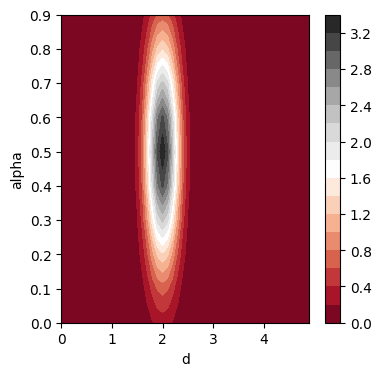

In [132]:
# # visualize P_alpha_d inital in subplots
# for i in range(num_frames):
#     contour_plt(P_alpha_d, i)
contour_plt(P_alpha_d, 50)

In [133]:
# load u_pred
u = np.loadtxt("u.txt")
print(f"shape of u : {u.shape}")
# print(u_pred)
# convert to torch tensor
u = torch.tensor(u, dtype=torch.float32, device=device)
print(f"shape of u : {u.shape}")

shape of u : (100, 500)
shape of u : torch.Size([100, 500])


In [134]:
# load Z
Z = np.load("Z.npy")
print(f"shape of Z : {Z.shape}")
# convert Z to torch tensor
Z = torch.from_numpy(Z).float().to(device)
# print shape of Z
print(f"shape of Z : {Z.shape}")
# print(Z)
# normalize Z to have integral of Z over r equal to 1
# Z = Z / np.sum(Z * (r_vals[1]-r_vals[0]))
# print(Z)

shape of Z : (10, 50, 100, 500)
shape of Z : torch.Size([10, 50, 100, 500])


In [135]:
def give_u_pred(P_alpha_d, Z, alpha_vals, d_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = torch.zeros((num_frames, len(r_vals)))
    # move u_pred to device
    u_pred = u_pred.to(device)

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = torch.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals)
            u_pred[i, j] = torch.trapz(integrand, alpha_vals)

    # normalize u_pred
    # u_pred = u_pred / (u_pred.sum(dim=1, keepdim=True) + 1e-9)
    # u_pred = u_pred / (torch.trapz(u_pred, k_vals, dim=1, keepdim=True))
    norm = torch.trapz(u_pred, k_vals, dim=1)
    u_pred = u_pred / norm[:, None]
    # u_pred = u_pred / np.trapz(u_pred, k_vals, axis=1).reshape(-1, 1)
    
    # norm = (torch.trapz(u_pred, k_vals, dim=1))

    # u_pred = u_pred / norm[:, None]


    return u_pred    

In [136]:
# manual loss function
def loss_function(P_alpha_d, u, Z, alpha_vals, d_vals, global_counter):
    # clamp P_alpha_d to be positive
    # P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)
    # normalize P_alpha_d
    norm = (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1))
    P_alpha_d = P_alpha_d / norm[:, None, None]
    # P_alpha_d = P_alpha_d / (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1, keepdim=True) + 1e-6)
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True))
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True) + 1e-6)
    # calculate u_pred using double integral
    u_pred = give_u_pred(P_alpha_d, Z, alpha_vals, d_vals)
    # calculate loss
    loss = torch.sum((u_pred - u)**2)
    # loss /= u.shape[0] * u.shape[1]
    # loss = torch.sum(abs(u_pred - u))
    # plot u_pred and u
    if(global_counter%5 == 0):
        plt.plot(u_pred.detach().cpu().numpy()[20], label='u_pred')
        plt.plot(u.detach().cpu().numpy()[20], label='u')
        plt.legend()
        plt.show()

    return loss

In [137]:
# write a function to train the model
def train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=100, lr=1e-1):
    # define the optimizer
    optimizer = torch.optim.Adam([P_alpha_d], lr=lr)
    # define the loss function
    loss_func = loss_function
    # define the loss history
    loss_history = []
    global_counter = 0
    # train the model
    for epoch in range(num_epochs):
        # calculate loss
        loss = loss_func(P_alpha_d, u, Z, alpha_vals, d_vals, global_counter)
        # zero the gradients
        optimizer.zero_grad()
        # backpropagate
        loss.backward()
        # update parameters
        optimizer.step()
        # append loss to loss history
        loss_history.append(loss.item())
        P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)
        global_counter += 1
        # plot P_alpha_d
        if (epoch+1) % 5 == 0:
            contour_plt(P_alpha_d, 50)
        # print loss
        if (epoch+1) % 1 == 0:
            print(f"epoch {epoch+1} / {num_epochs} : loss = {loss.item()}")
    # plot loss history
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return P_alpha_d

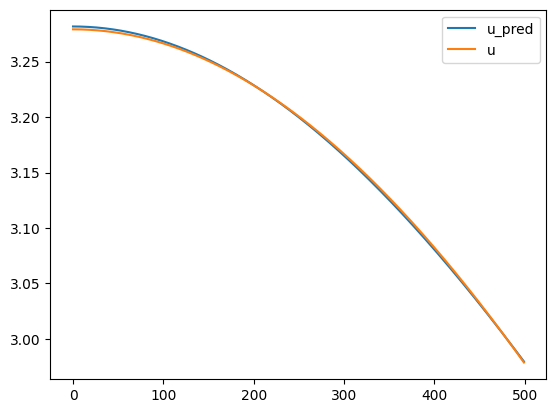

epoch 1 / 500 : loss = 6.896994113922119
epoch 2 / 500 : loss = 6.043514251708984
epoch 3 / 500 : loss = 5.433213710784912
epoch 4 / 500 : loss = 4.971060752868652


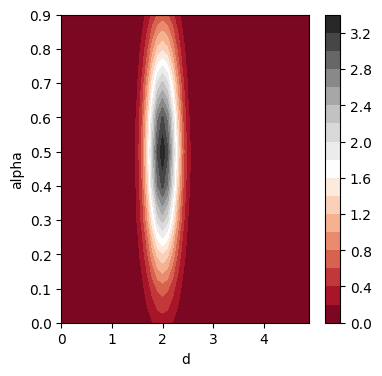

epoch 5 / 500 : loss = 4.561363697052002


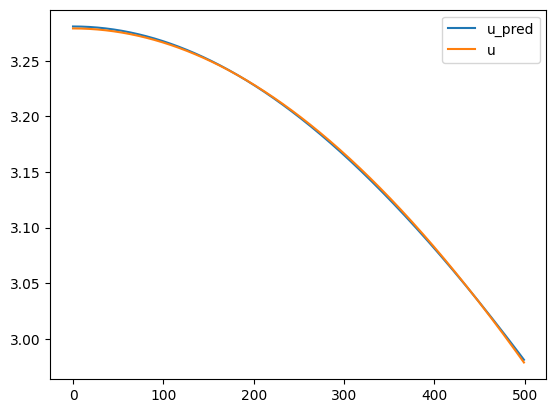

epoch 6 / 500 : loss = 4.171448707580566
epoch 7 / 500 : loss = 3.8012189865112305
epoch 8 / 500 : loss = 3.463210344314575
epoch 9 / 500 : loss = 3.160451650619507


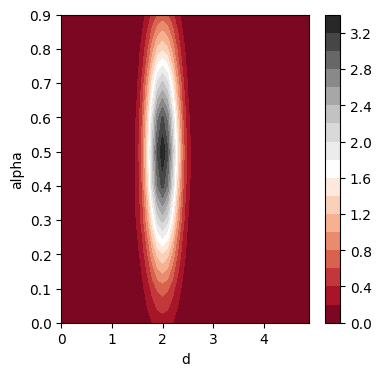

epoch 10 / 500 : loss = 2.89382004737854


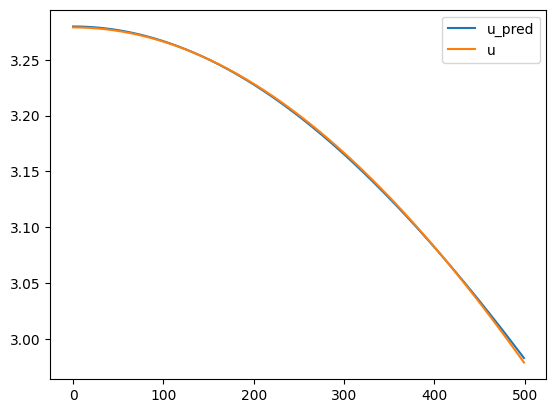

epoch 11 / 500 : loss = 2.6606149673461914
epoch 12 / 500 : loss = 2.4520978927612305
epoch 13 / 500 : loss = 2.260735273361206
epoch 14 / 500 : loss = 2.081949472427368


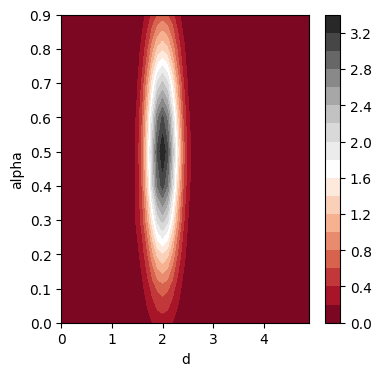

epoch 15 / 500 : loss = 1.9150114059448242


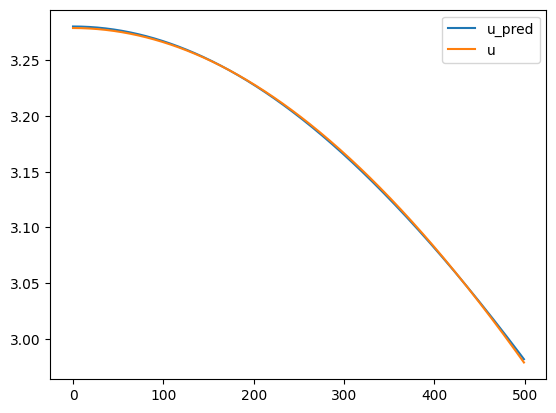

epoch 16 / 500 : loss = 1.7632980346679688
epoch 17 / 500 : loss = 1.6267732381820679
epoch 18 / 500 : loss = 1.5042641162872314
epoch 19 / 500 : loss = 1.3939192295074463


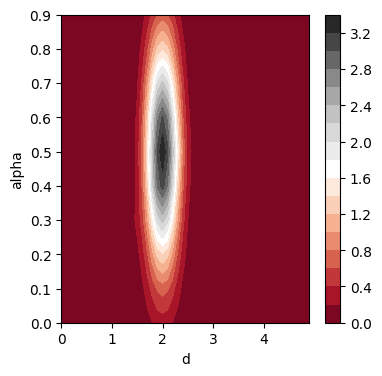

epoch 20 / 500 : loss = 1.2940434217453003


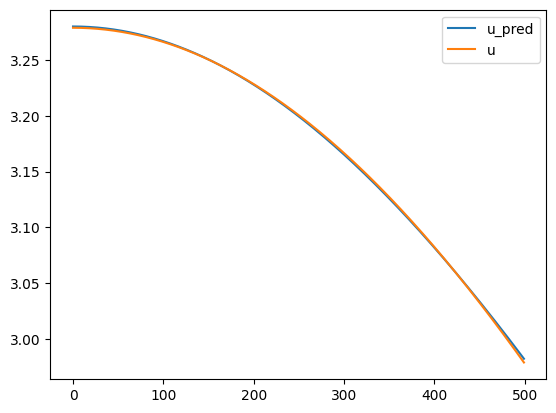

epoch 21 / 500 : loss = 1.202100396156311
epoch 22 / 500 : loss = 1.1161657571792603
epoch 23 / 500 : loss = 1.0355772972106934
epoch 24 / 500 : loss = 0.9607979655265808


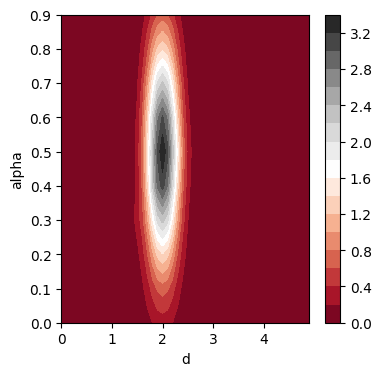

epoch 25 / 500 : loss = 0.8922911882400513


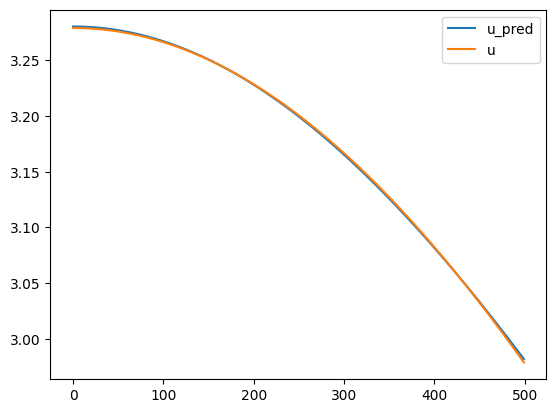

epoch 26 / 500 : loss = 0.8305081129074097
epoch 27 / 500 : loss = 0.7752286195755005
epoch 28 / 500 : loss = 0.7253583073616028
epoch 29 / 500 : loss = 0.6802186369895935


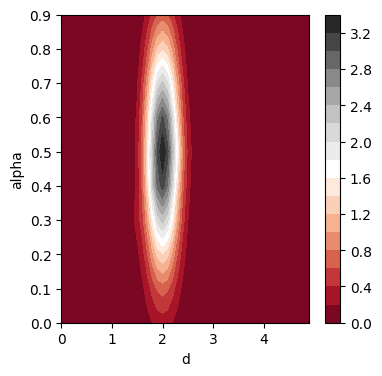

epoch 30 / 500 : loss = 0.6385294198989868


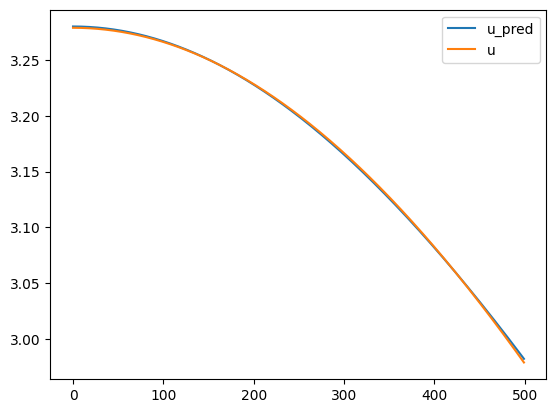

epoch 31 / 500 : loss = 0.5997512936592102
epoch 32 / 500 : loss = 0.5637328028678894
epoch 33 / 500 : loss = 0.5303139686584473
epoch 34 / 500 : loss = 0.4995236098766327


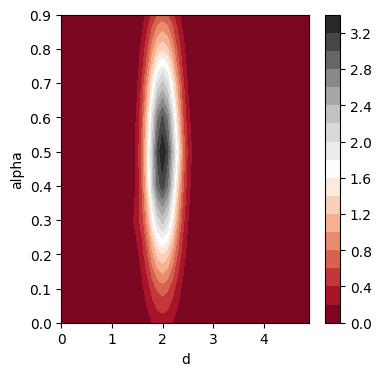

epoch 35 / 500 : loss = 0.4708198606967926


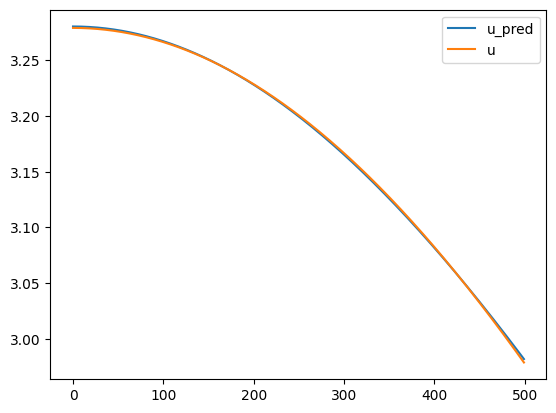

epoch 36 / 500 : loss = 0.4441438317298889
epoch 37 / 500 : loss = 0.4192960560321808
epoch 38 / 500 : loss = 0.3960764408111572
epoch 39 / 500 : loss = 0.3744562566280365


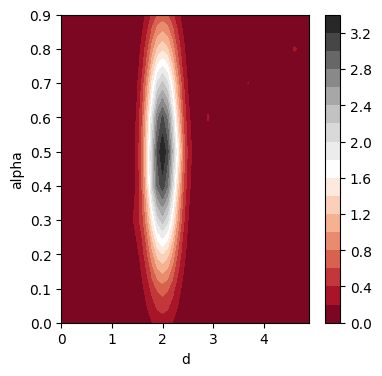

epoch 40 / 500 : loss = 0.35448914766311646


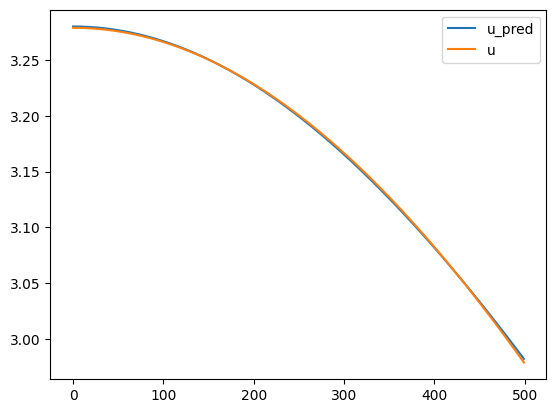

epoch 41 / 500 : loss = 0.33613112568855286
epoch 42 / 500 : loss = 0.319256067276001
epoch 43 / 500 : loss = 0.3037901222705841
epoch 44 / 500 : loss = 0.28962063789367676


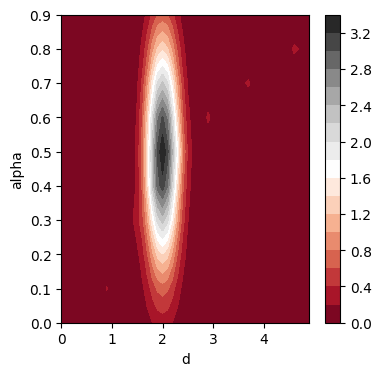

epoch 45 / 500 : loss = 0.2766244411468506


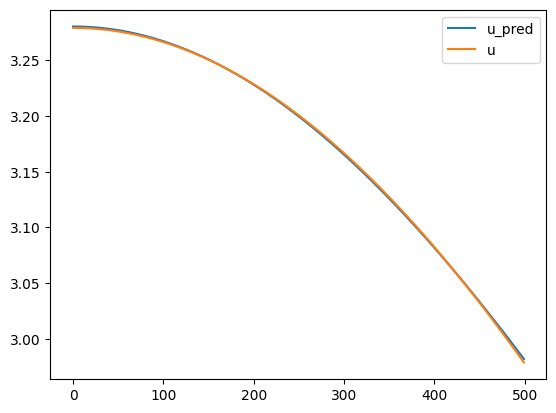

epoch 46 / 500 : loss = 0.2647264003753662
epoch 47 / 500 : loss = 0.25388213992118835
epoch 48 / 500 : loss = 0.2440539300441742
epoch 49 / 500 : loss = 0.23518645763397217


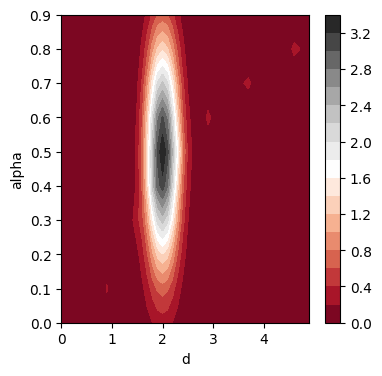

epoch 50 / 500 : loss = 0.2271895408630371


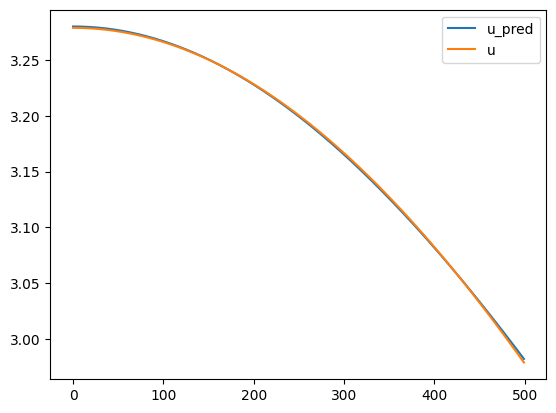

epoch 51 / 500 : loss = 0.21994104981422424
epoch 52 / 500 : loss = 0.21331633627414703
epoch 53 / 500 : loss = 0.20721077919006348
epoch 54 / 500 : loss = 0.2015637755393982


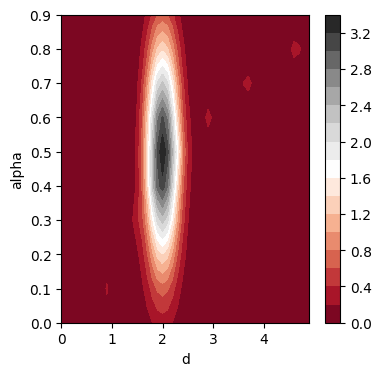

epoch 55 / 500 : loss = 0.19634810090065002


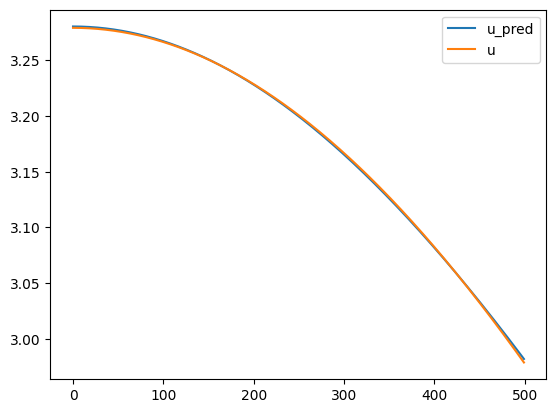

epoch 56 / 500 : loss = 0.19151896238327026
epoch 57 / 500 : loss = 0.18707014620304108
epoch 58 / 500 : loss = 0.1829676330089569
epoch 59 / 500 : loss = 0.17920804023742676


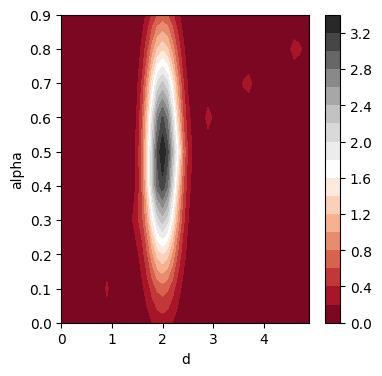

epoch 60 / 500 : loss = 0.17577752470970154


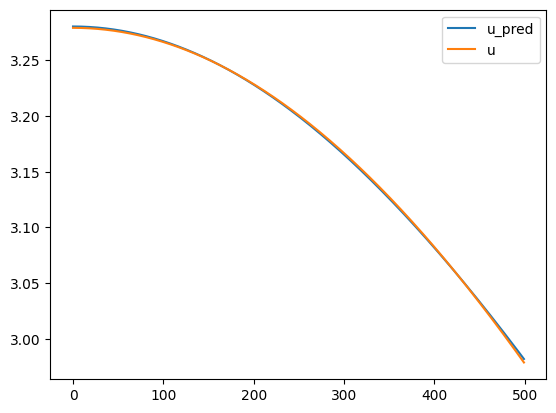

epoch 61 / 500 : loss = 0.17266535758972168
epoch 62 / 500 : loss = 0.16987484693527222
epoch 63 / 500 : loss = 0.16739417612552643
epoch 64 / 500 : loss = 0.16519854962825775


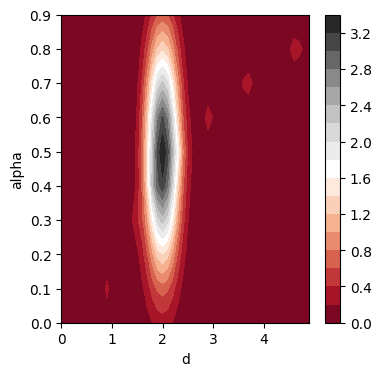

epoch 65 / 500 : loss = 0.16325074434280396


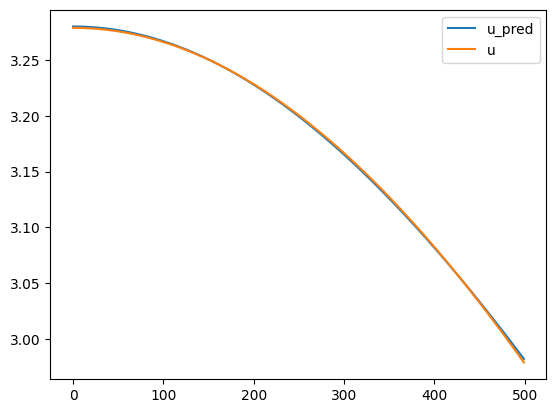

epoch 66 / 500 : loss = 0.1615116000175476
epoch 67 / 500 : loss = 0.1599486917257309
epoch 68 / 500 : loss = 0.15854115784168243
epoch 69 / 500 : loss = 0.1572721004486084


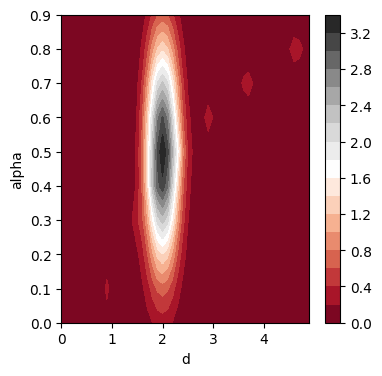

epoch 70 / 500 : loss = 0.1561286598443985


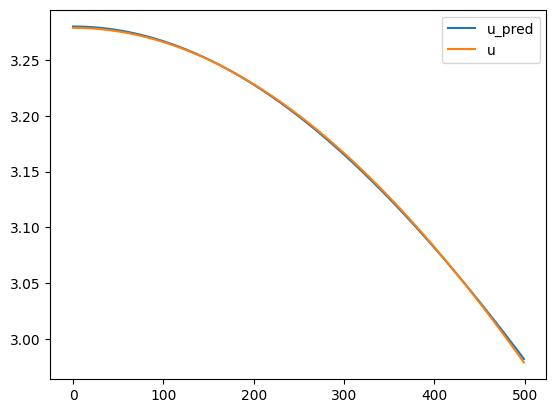

epoch 71 / 500 : loss = 0.15509909391403198
epoch 72 / 500 : loss = 0.15416809916496277
epoch 73 / 500 : loss = 0.15332552790641785
epoch 74 / 500 : loss = 0.15256309509277344


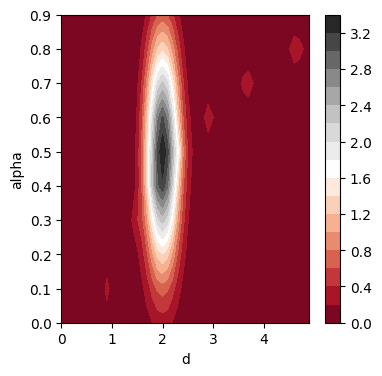

epoch 75 / 500 : loss = 0.1518775224685669


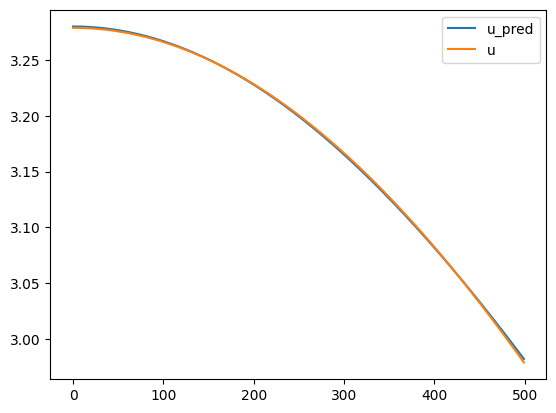

epoch 76 / 500 : loss = 0.15126574039459229
epoch 77 / 500 : loss = 0.15072330832481384
epoch 78 / 500 : loss = 0.1502440869808197
epoch 79 / 500 : loss = 0.1498192548751831


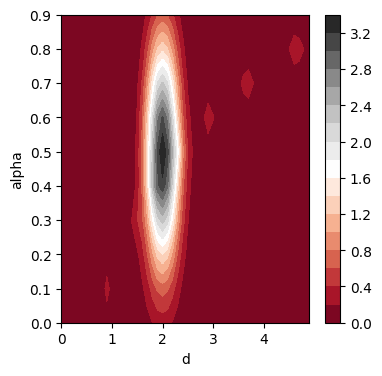

epoch 80 / 500 : loss = 0.14944203197956085


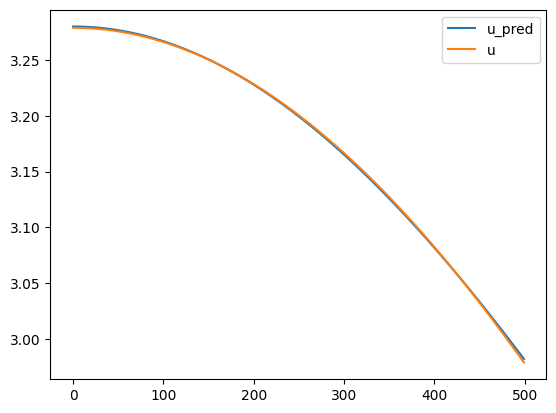

epoch 81 / 500 : loss = 0.1491074562072754
epoch 82 / 500 : loss = 0.1488155871629715
epoch 83 / 500 : loss = 0.1485571414232254
epoch 84 / 500 : loss = 0.14833039045333862


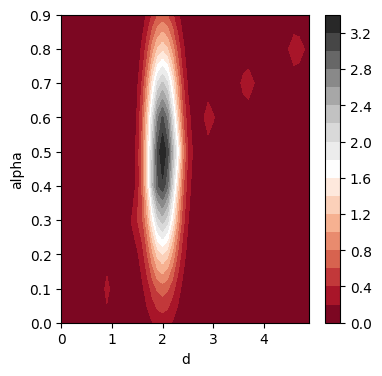

epoch 85 / 500 : loss = 0.14812755584716797


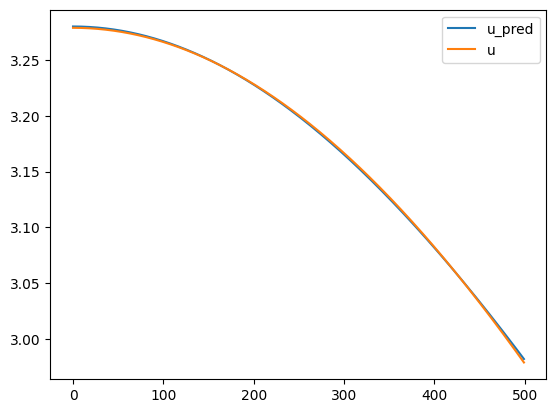

epoch 86 / 500 : loss = 0.1479455977678299
epoch 87 / 500 : loss = 0.14778052270412445
epoch 88 / 500 : loss = 0.1476307362318039
epoch 89 / 500 : loss = 0.14749449491500854


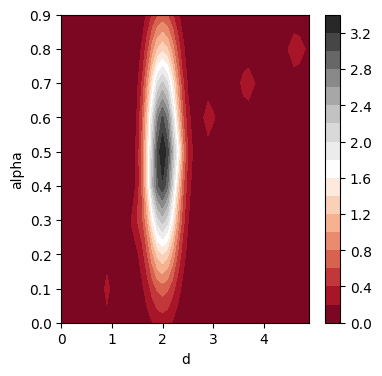

epoch 90 / 500 : loss = 0.14737021923065186


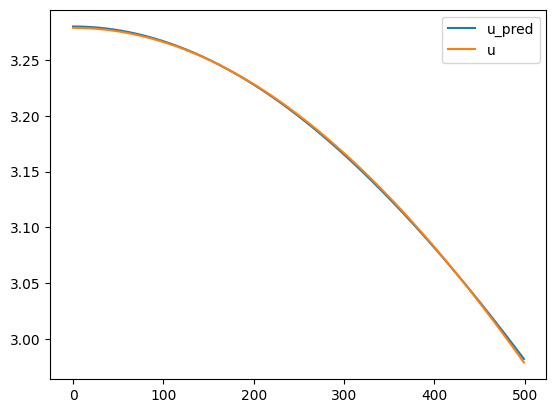

epoch 91 / 500 : loss = 0.14725662767887115
epoch 92 / 500 : loss = 0.1471506804227829
epoch 93 / 500 : loss = 0.14705127477645874
epoch 94 / 500 : loss = 0.14695794880390167


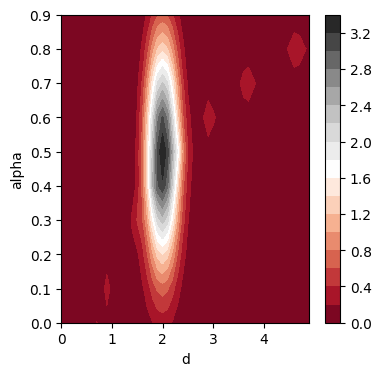

epoch 95 / 500 : loss = 0.14687034487724304


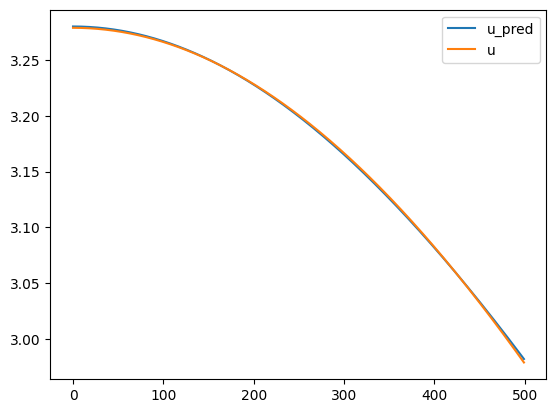

epoch 96 / 500 : loss = 0.14678800106048584
epoch 97 / 500 : loss = 0.14670905470848083
epoch 98 / 500 : loss = 0.14663459360599518
epoch 99 / 500 : loss = 0.14656241238117218


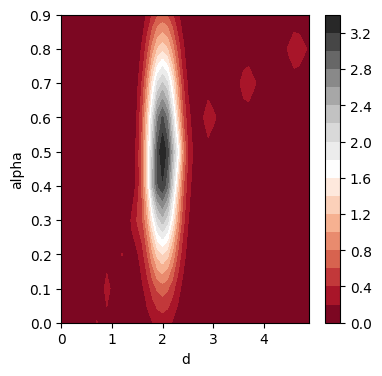

epoch 100 / 500 : loss = 0.1464921534061432


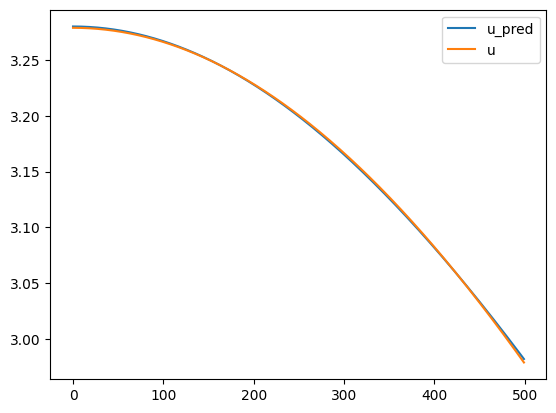

epoch 101 / 500 : loss = 0.14642414450645447
epoch 102 / 500 : loss = 0.1463579535484314
epoch 103 / 500 : loss = 0.1462930589914322
epoch 104 / 500 : loss = 0.1462300717830658


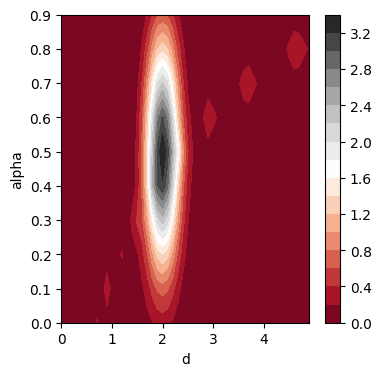

epoch 105 / 500 : loss = 0.1461676061153412


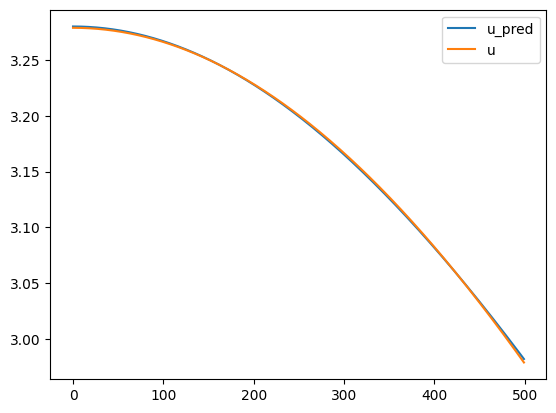

epoch 106 / 500 : loss = 0.14610575139522552
epoch 107 / 500 : loss = 0.14604446291923523
epoch 108 / 500 : loss = 0.14598298072814941
epoch 109 / 500 : loss = 0.14592188596725464


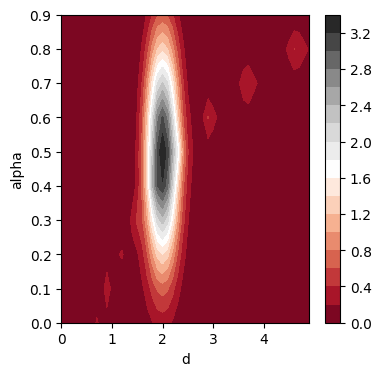

epoch 110 / 500 : loss = 0.14586105942726135


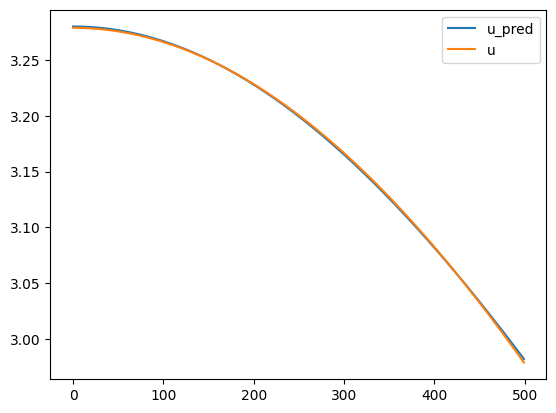

epoch 111 / 500 : loss = 0.14580018818378448
epoch 112 / 500 : loss = 0.14573903381824493
epoch 113 / 500 : loss = 0.14567780494689941
epoch 114 / 500 : loss = 0.14561688899993896


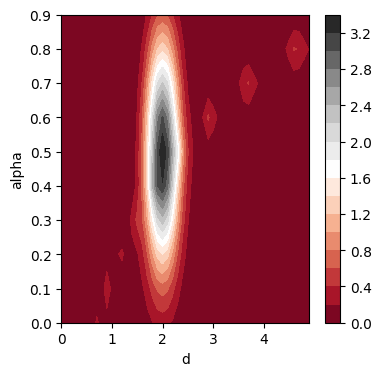

epoch 115 / 500 : loss = 0.14555586874485016


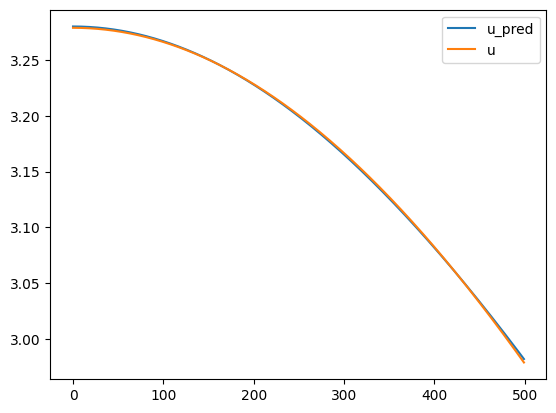

epoch 116 / 500 : loss = 0.1454949527978897
epoch 117 / 500 : loss = 0.1454339623451233
epoch 118 / 500 : loss = 0.14537307620048523
epoch 119 / 500 : loss = 0.14531205594539642


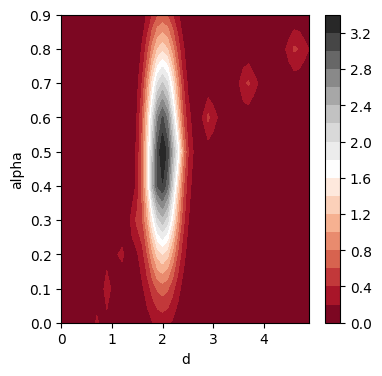

epoch 120 / 500 : loss = 0.14525143802165985


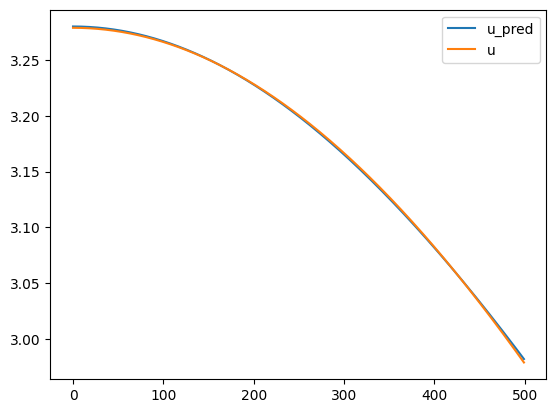

epoch 121 / 500 : loss = 0.14519137144088745
epoch 122 / 500 : loss = 0.14513112604618073
epoch 123 / 500 : loss = 0.14507117867469788
epoch 124 / 500 : loss = 0.14501148462295532


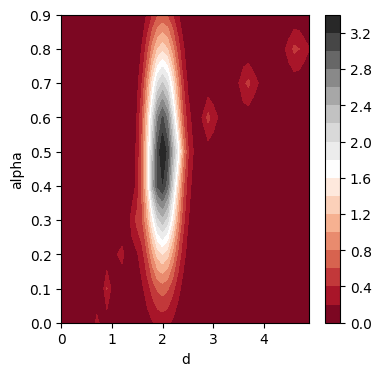

epoch 125 / 500 : loss = 0.14495235681533813


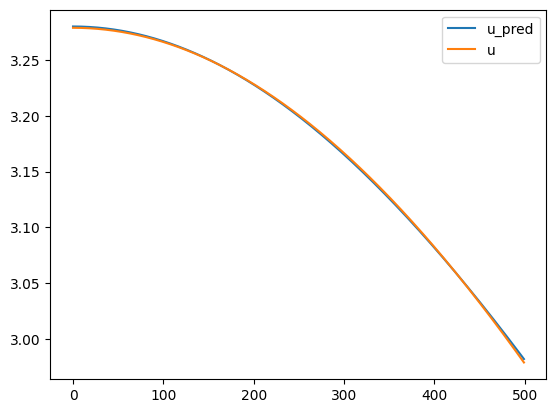

epoch 126 / 500 : loss = 0.14489349722862244
epoch 127 / 500 : loss = 0.14483517408370972
epoch 128 / 500 : loss = 0.14477726817131042
epoch 129 / 500 : loss = 0.14471952617168427


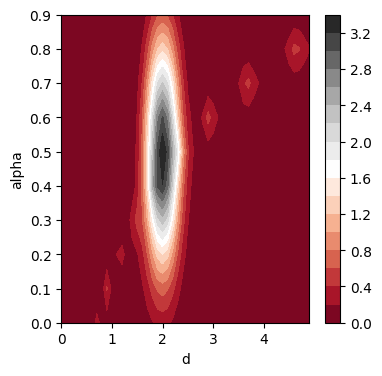

epoch 130 / 500 : loss = 0.1446622610092163


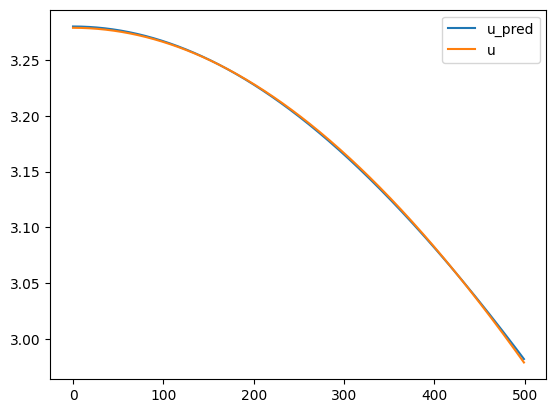

epoch 131 / 500 : loss = 0.1446053385734558
epoch 132 / 500 : loss = 0.14454850554466248
epoch 133 / 500 : loss = 0.14449255168437958
epoch 134 / 500 : loss = 0.14443697035312653


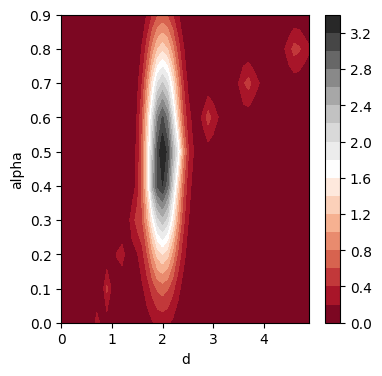

epoch 135 / 500 : loss = 0.14438165724277496


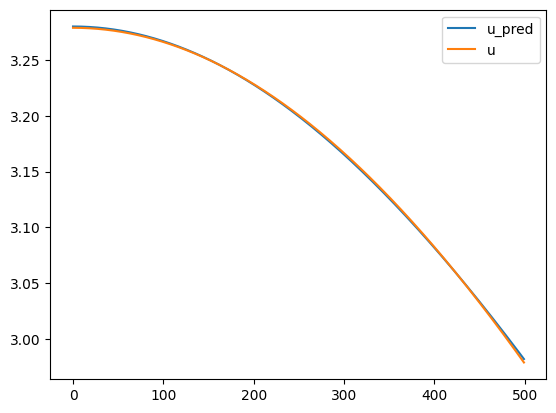

epoch 136 / 500 : loss = 0.14432647824287415
epoch 137 / 500 : loss = 0.1442715972661972
epoch 138 / 500 : loss = 0.14421731233596802
epoch 139 / 500 : loss = 0.14416290819644928


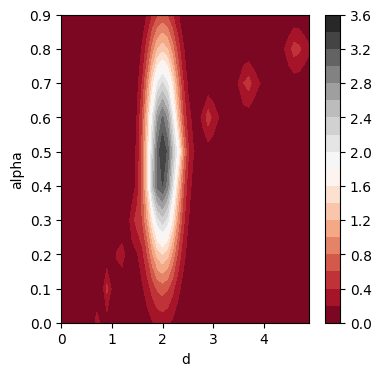

epoch 140 / 500 : loss = 0.1441088616847992


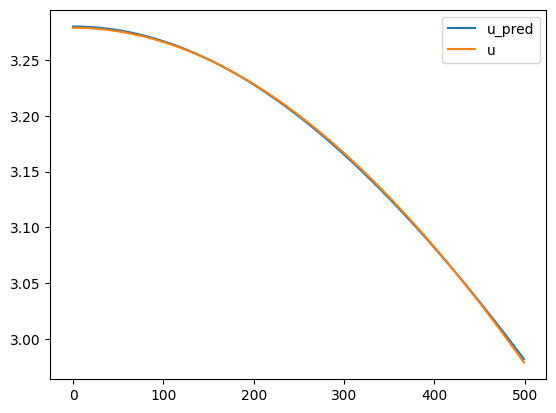

epoch 141 / 500 : loss = 0.14405563473701477
epoch 142 / 500 : loss = 0.14400218427181244
epoch 143 / 500 : loss = 0.14394892752170563
epoch 144 / 500 : loss = 0.14389583468437195


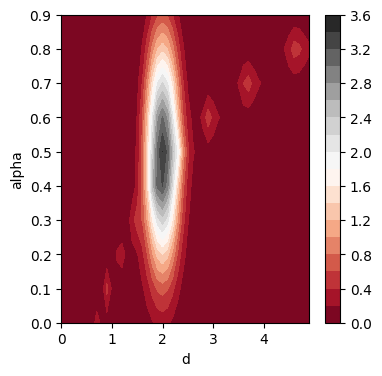

epoch 145 / 500 : loss = 0.14384303987026215


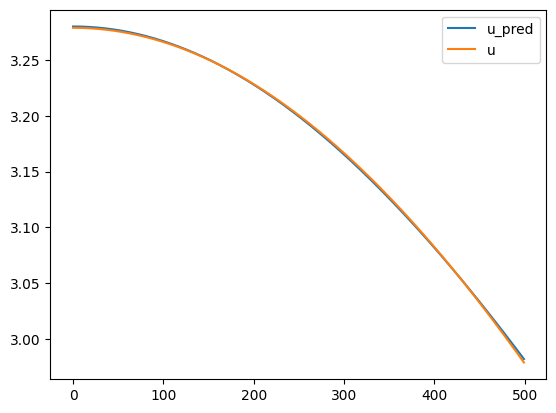

epoch 146 / 500 : loss = 0.1437903493642807
epoch 147 / 500 : loss = 0.14373779296875
epoch 148 / 500 : loss = 0.1436857283115387
epoch 149 / 500 : loss = 0.14363357424736023


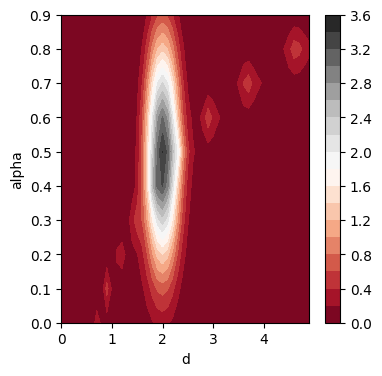

epoch 150 / 500 : loss = 0.1435818076133728


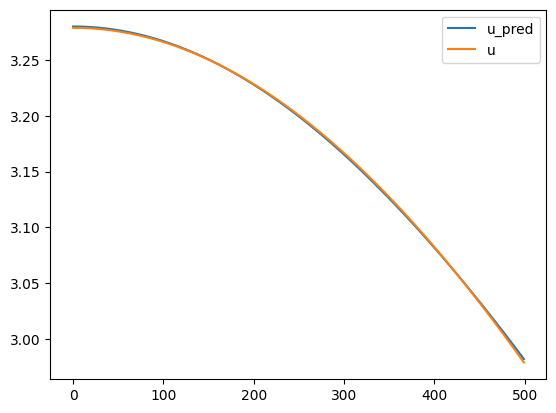

epoch 151 / 500 : loss = 0.14353018999099731
epoch 152 / 500 : loss = 0.1434786319732666
epoch 153 / 500 : loss = 0.14342719316482544
epoch 154 / 500 : loss = 0.14337566494941711


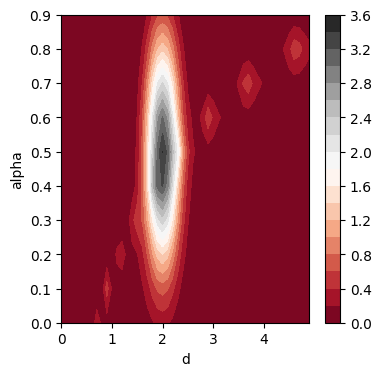

epoch 155 / 500 : loss = 0.1433248221874237


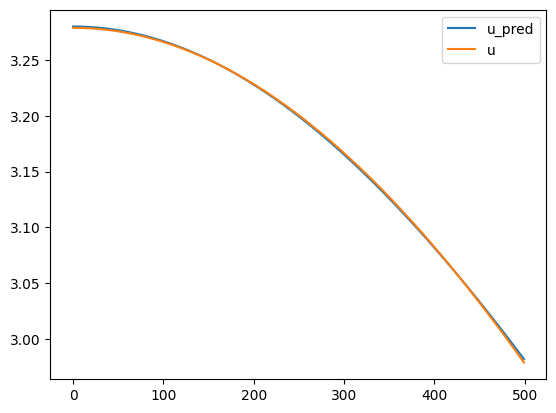

epoch 156 / 500 : loss = 0.14327330887317657
epoch 157 / 500 : loss = 0.1432223916053772
epoch 158 / 500 : loss = 0.14317135512828827
epoch 159 / 500 : loss = 0.14312073588371277


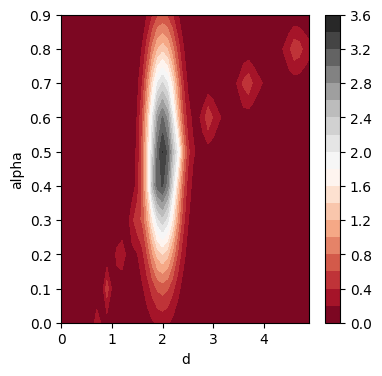

epoch 160 / 500 : loss = 0.1430700123310089


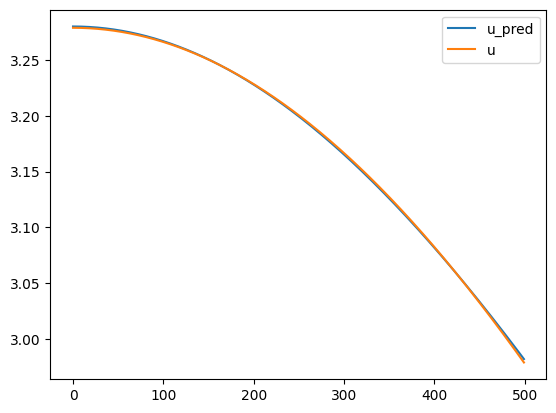

epoch 161 / 500 : loss = 0.14301937818527222
epoch 162 / 500 : loss = 0.14296886324882507
epoch 163 / 500 : loss = 0.1429184079170227
epoch 164 / 500 : loss = 0.14286838471889496


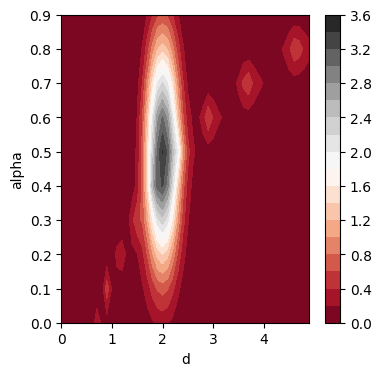

epoch 165 / 500 : loss = 0.1428181678056717


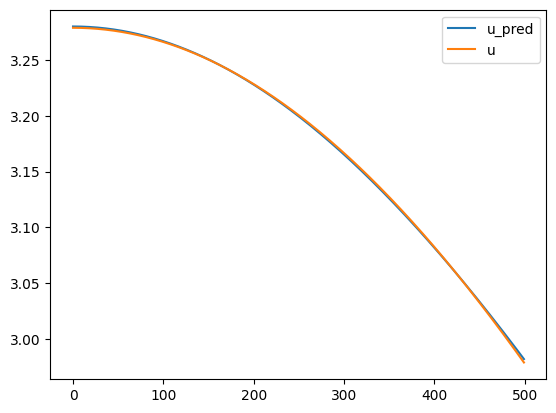

epoch 166 / 500 : loss = 0.14276818931102753
epoch 167 / 500 : loss = 0.14271870255470276
epoch 168 / 500 : loss = 0.14266884326934814
epoch 169 / 500 : loss = 0.14261916279792786


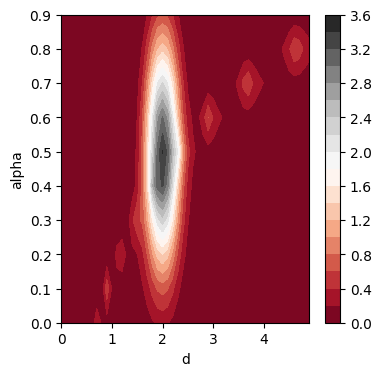

epoch 170 / 500 : loss = 0.14257019758224487


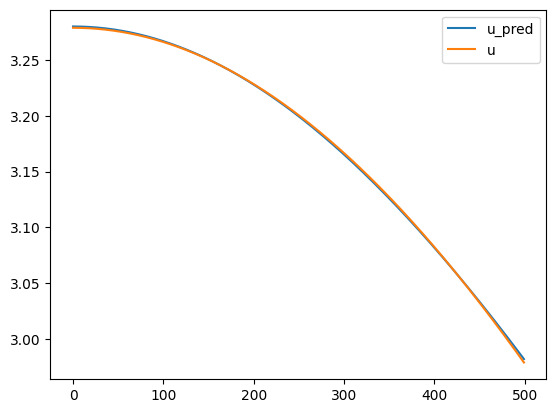

epoch 171 / 500 : loss = 0.14252088963985443
epoch 172 / 500 : loss = 0.14247138798236847
epoch 173 / 500 : loss = 0.14242206513881683
epoch 174 / 500 : loss = 0.142373189330101


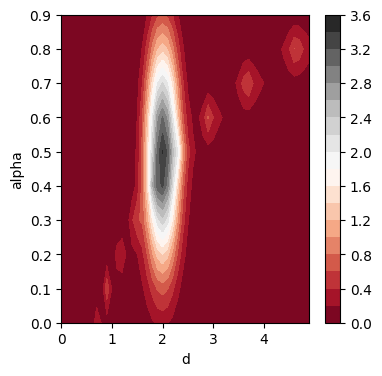

epoch 175 / 500 : loss = 0.1423238217830658


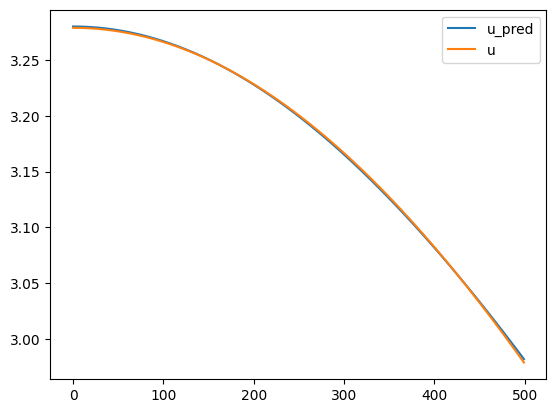

epoch 176 / 500 : loss = 0.14227479696273804
epoch 177 / 500 : loss = 0.1422257423400879
epoch 178 / 500 : loss = 0.1421767771244049
epoch 179 / 500 : loss = 0.14212800562381744


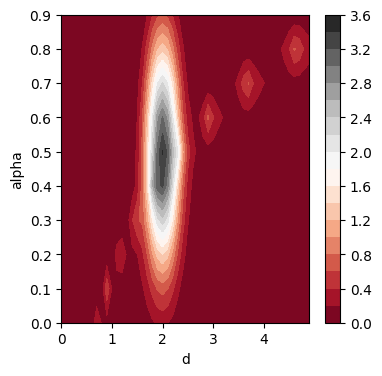

epoch 180 / 500 : loss = 0.14207889139652252


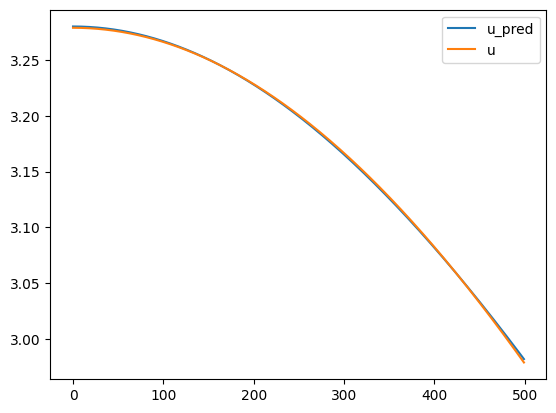

epoch 181 / 500 : loss = 0.14203029870986938
epoch 182 / 500 : loss = 0.14198140799999237
epoch 183 / 500 : loss = 0.14193260669708252
epoch 184 / 500 : loss = 0.14188407361507416


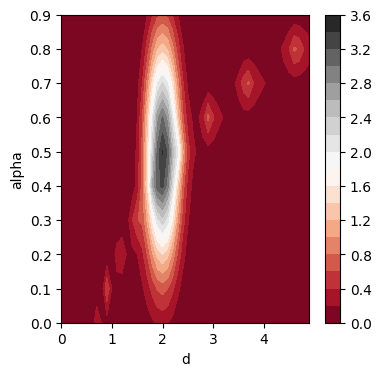

epoch 185 / 500 : loss = 0.14183583855628967


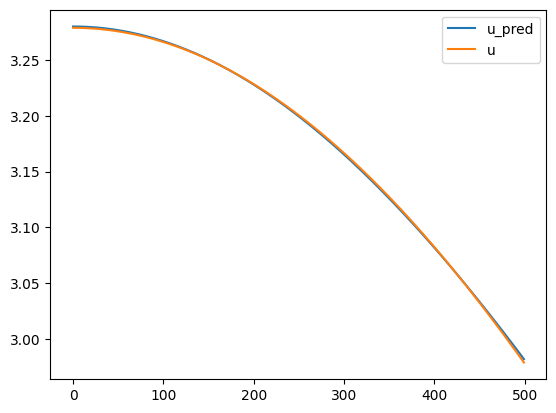

epoch 186 / 500 : loss = 0.14178763329982758
epoch 187 / 500 : loss = 0.1417398601770401
epoch 188 / 500 : loss = 0.14169181883335114
epoch 189 / 500 : loss = 0.14164456725120544


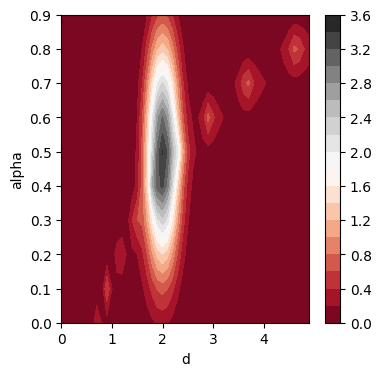

epoch 190 / 500 : loss = 0.1415967047214508


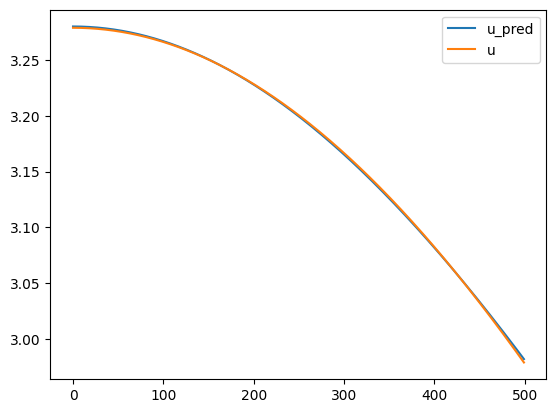

epoch 191 / 500 : loss = 0.14154848456382751
epoch 192 / 500 : loss = 0.1415008306503296
epoch 193 / 500 : loss = 0.14145304262638092
epoch 194 / 500 : loss = 0.14140528440475464


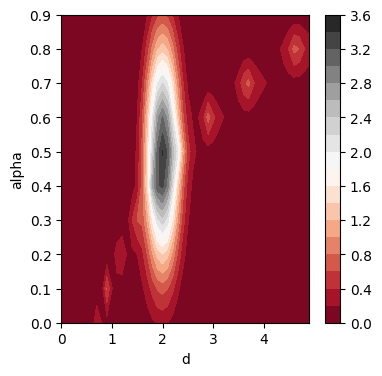

epoch 195 / 500 : loss = 0.14135755598545074


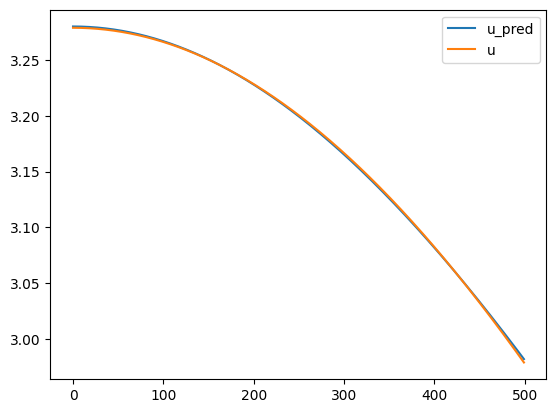

epoch 196 / 500 : loss = 0.1413099318742752
epoch 197 / 500 : loss = 0.14126229286193848
epoch 198 / 500 : loss = 0.14121490716934204
epoch 199 / 500 : loss = 0.1411670744419098


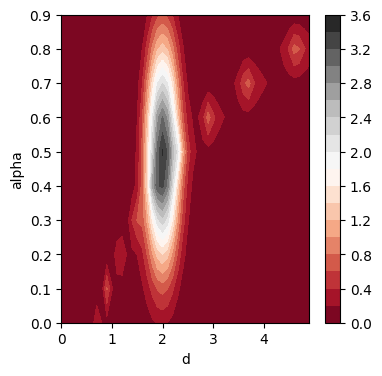

epoch 200 / 500 : loss = 0.14111948013305664


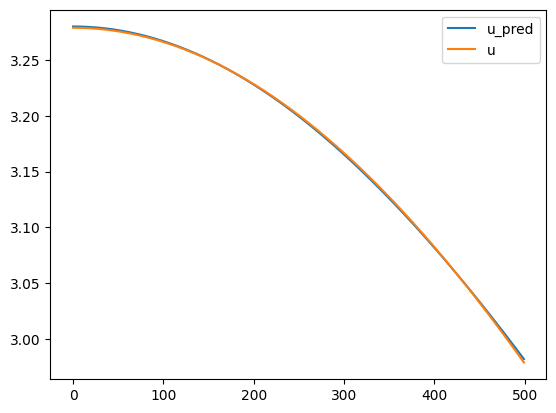

epoch 201 / 500 : loss = 0.14107175171375275
epoch 202 / 500 : loss = 0.14102458953857422
epoch 203 / 500 : loss = 0.14097727835178375
epoch 204 / 500 : loss = 0.14093002676963806


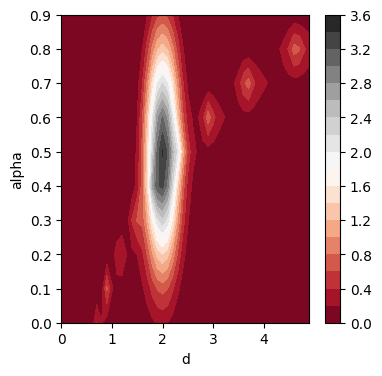

epoch 205 / 500 : loss = 0.14088322222232819


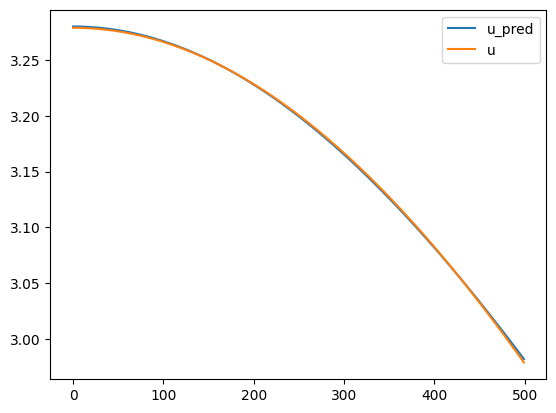

epoch 206 / 500 : loss = 0.14083585143089294
epoch 207 / 500 : loss = 0.1407890021800995
epoch 208 / 500 : loss = 0.14074251055717468
epoch 209 / 500 : loss = 0.14069604873657227


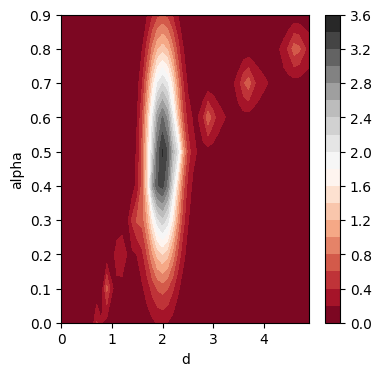

epoch 210 / 500 : loss = 0.14064981043338776


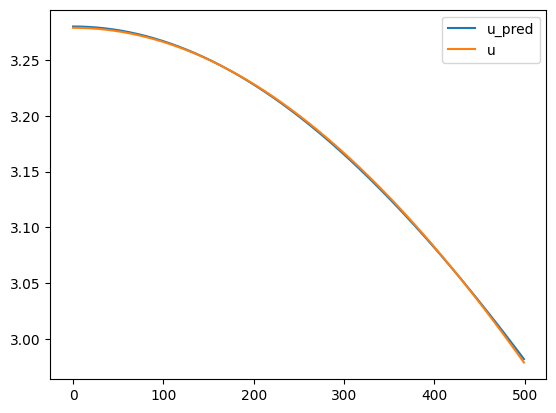

epoch 211 / 500 : loss = 0.14060324430465698
epoch 212 / 500 : loss = 0.14055675268173218
epoch 213 / 500 : loss = 0.1405102163553238
epoch 214 / 500 : loss = 0.14046421647071838


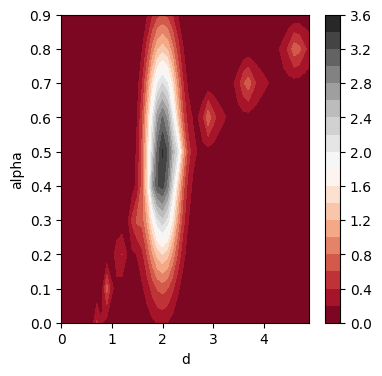

epoch 215 / 500 : loss = 0.14041727781295776


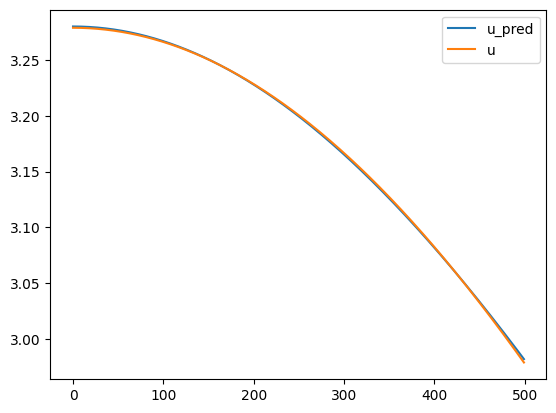

epoch 216 / 500 : loss = 0.14037105441093445
epoch 217 / 500 : loss = 0.1403246521949768
epoch 218 / 500 : loss = 0.14027857780456543
epoch 219 / 500 : loss = 0.14023242890834808


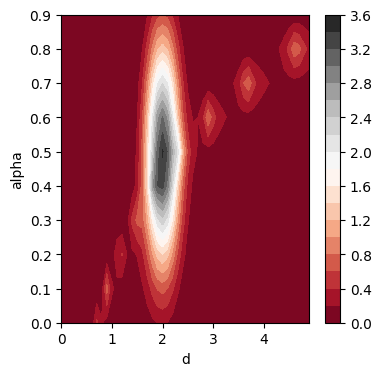

epoch 220 / 500 : loss = 0.14018560945987701


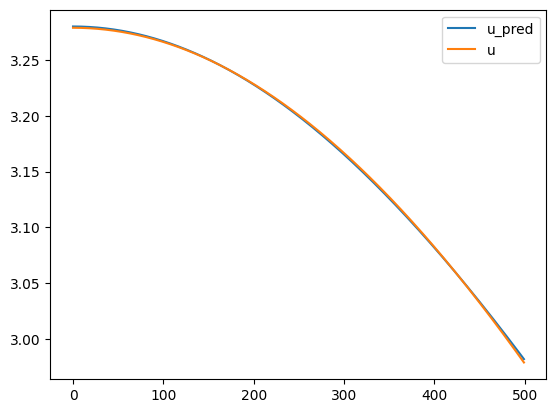

epoch 221 / 500 : loss = 0.1401396244764328
epoch 222 / 500 : loss = 0.14009328186511993
epoch 223 / 500 : loss = 0.140047088265419
epoch 224 / 500 : loss = 0.14000098407268524


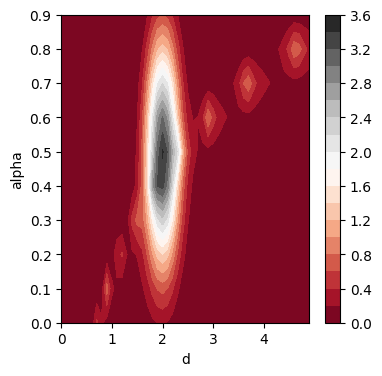

epoch 225 / 500 : loss = 0.139955073595047


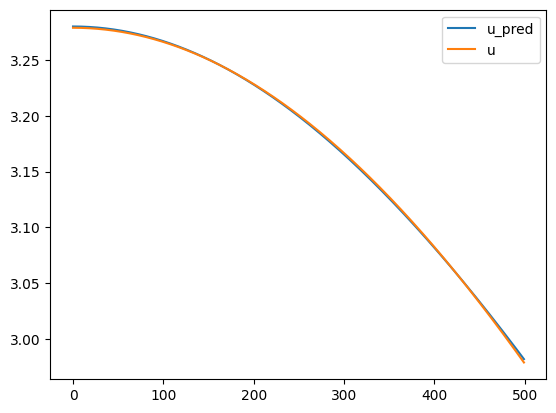

epoch 226 / 500 : loss = 0.13990861177444458
epoch 227 / 500 : loss = 0.13986264169216156
epoch 228 / 500 : loss = 0.13981671631336212
epoch 229 / 500 : loss = 0.13977105915546417


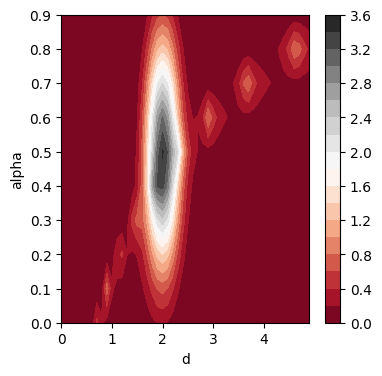

epoch 230 / 500 : loss = 0.1397252082824707


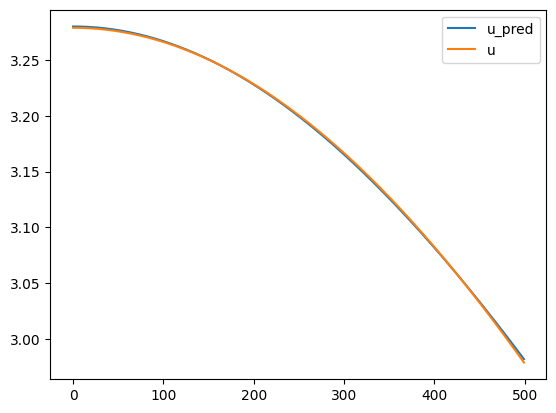

epoch 231 / 500 : loss = 0.13967907428741455
epoch 232 / 500 : loss = 0.1396332085132599
epoch 233 / 500 : loss = 0.13958726823329926
epoch 234 / 500 : loss = 0.13954198360443115


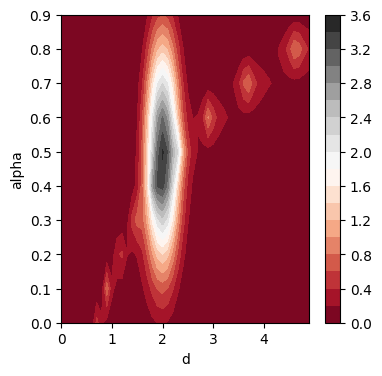

epoch 235 / 500 : loss = 0.13949616253376007


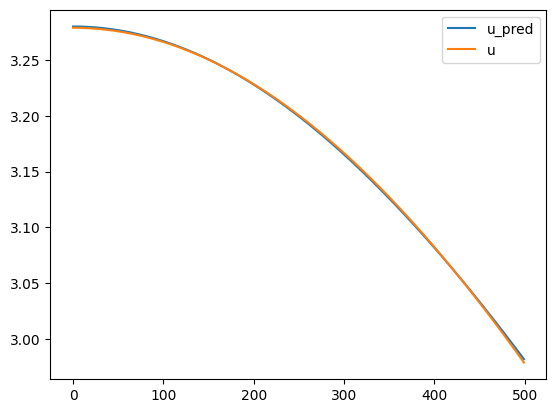

epoch 236 / 500 : loss = 0.13945136964321136
epoch 237 / 500 : loss = 0.139405757188797
epoch 238 / 500 : loss = 0.13936050236225128
epoch 239 / 500 : loss = 0.13931554555892944


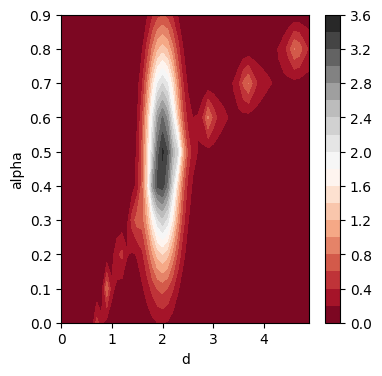

epoch 240 / 500 : loss = 0.13927026093006134


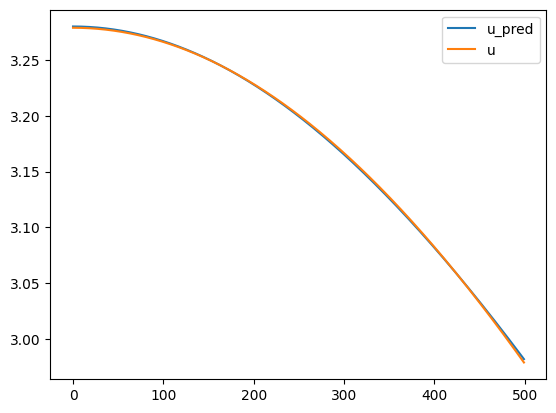

epoch 241 / 500 : loss = 0.1392248123884201
epoch 242 / 500 : loss = 0.13917991518974304
epoch 243 / 500 : loss = 0.1391347199678421
epoch 244 / 500 : loss = 0.13908958435058594


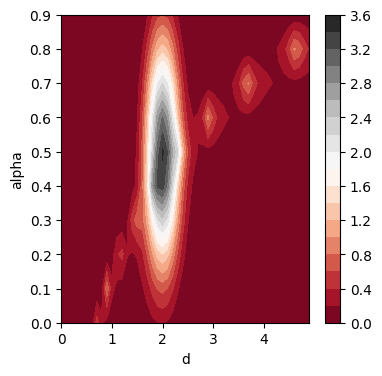

epoch 245 / 500 : loss = 0.1390446126461029


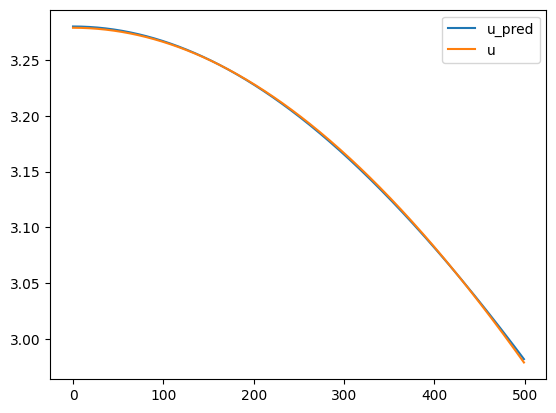

epoch 246 / 500 : loss = 0.13899943232536316
epoch 247 / 500 : loss = 0.138954758644104
epoch 248 / 500 : loss = 0.1389094889163971
epoch 249 / 500 : loss = 0.13886485993862152


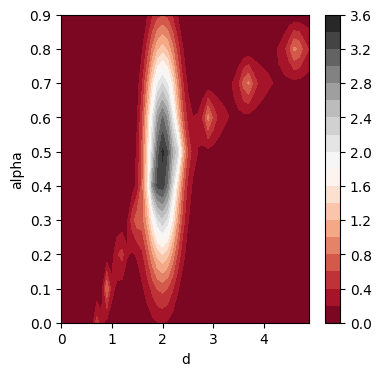

epoch 250 / 500 : loss = 0.13882002234458923


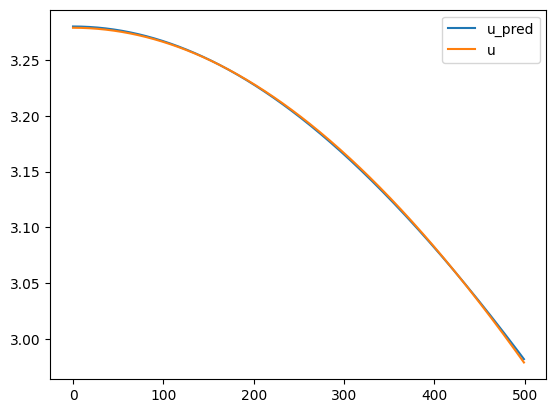

epoch 251 / 500 : loss = 0.13877512514591217
epoch 252 / 500 : loss = 0.13873037695884705
epoch 253 / 500 : loss = 0.13868550956249237
epoch 254 / 500 : loss = 0.1386408507823944


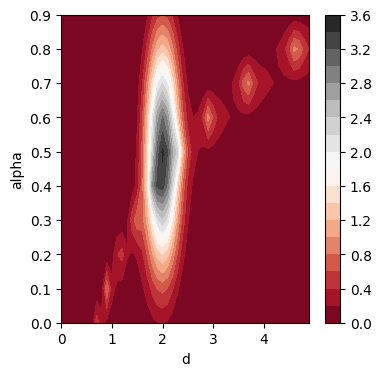

epoch 255 / 500 : loss = 0.1385962963104248


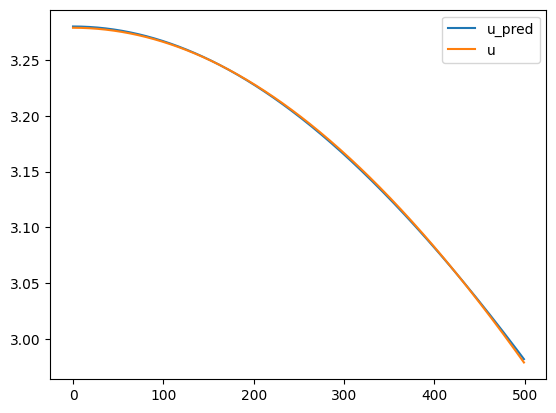

epoch 256 / 500 : loss = 0.13855133950710297
epoch 257 / 500 : loss = 0.13850653171539307
epoch 258 / 500 : loss = 0.13846205174922943
epoch 259 / 500 : loss = 0.13841719925403595


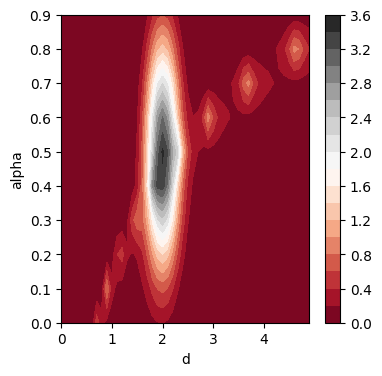

epoch 260 / 500 : loss = 0.1383727341890335


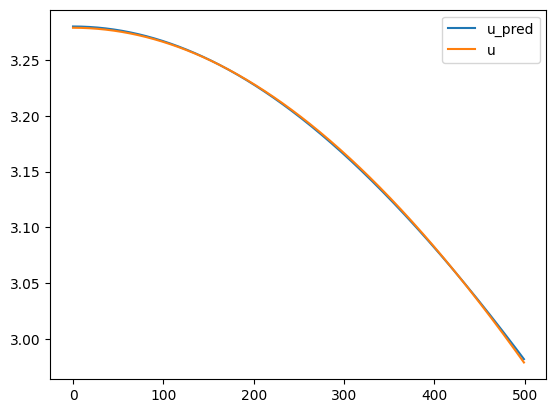

epoch 261 / 500 : loss = 0.13832814991474152
epoch 262 / 500 : loss = 0.1382836252450943
epoch 263 / 500 : loss = 0.13823914527893066
epoch 264 / 500 : loss = 0.13819490373134613


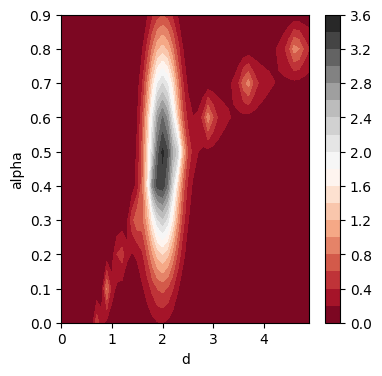

epoch 265 / 500 : loss = 0.13815054297447205


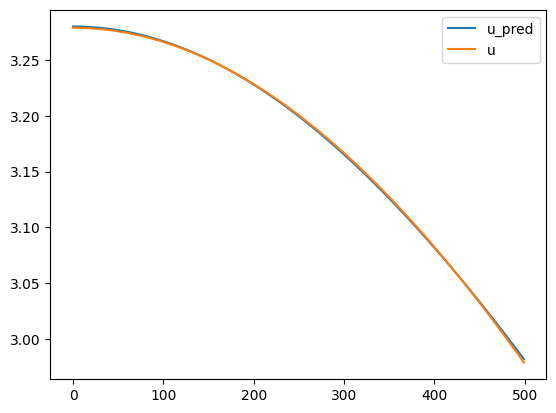

epoch 266 / 500 : loss = 0.13810600340366364
epoch 267 / 500 : loss = 0.13806207478046417
epoch 268 / 500 : loss = 0.13801777362823486
epoch 269 / 500 : loss = 0.13797354698181152


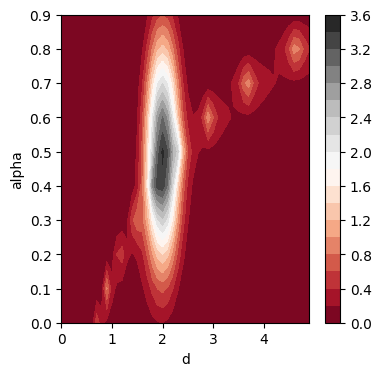

epoch 270 / 500 : loss = 0.13792897760868073


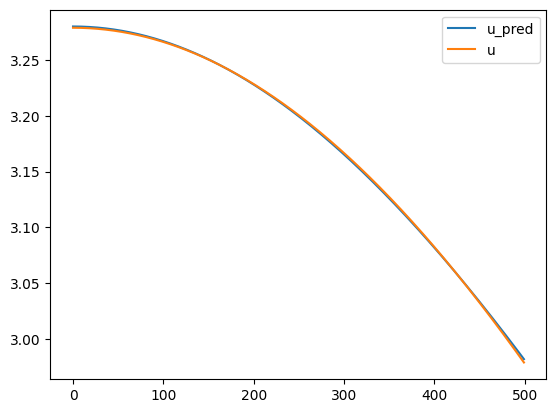

epoch 271 / 500 : loss = 0.13788489997386932
epoch 272 / 500 : loss = 0.1378411501646042
epoch 273 / 500 : loss = 0.13779693841934204
epoch 274 / 500 : loss = 0.13775254786014557


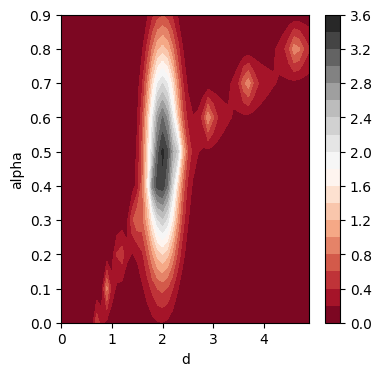

epoch 275 / 500 : loss = 0.1377083957195282


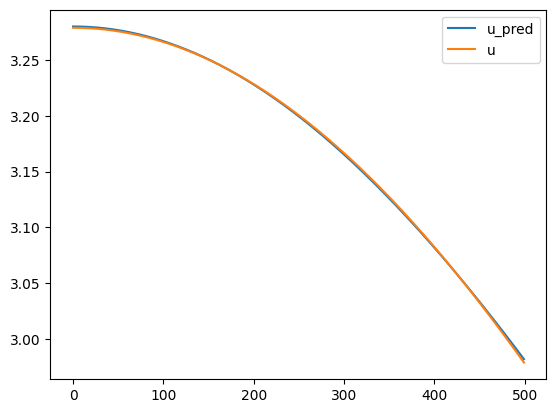

epoch 276 / 500 : loss = 0.1376643031835556
epoch 277 / 500 : loss = 0.13762003183364868
epoch 278 / 500 : loss = 0.13757604360580444
epoch 279 / 500 : loss = 0.13753201067447662


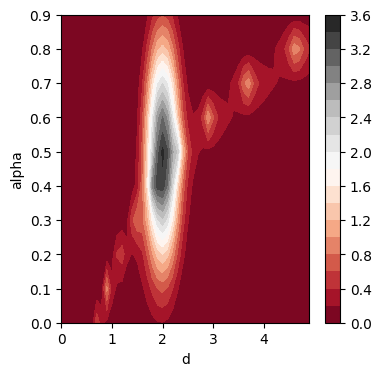

epoch 280 / 500 : loss = 0.13748791813850403


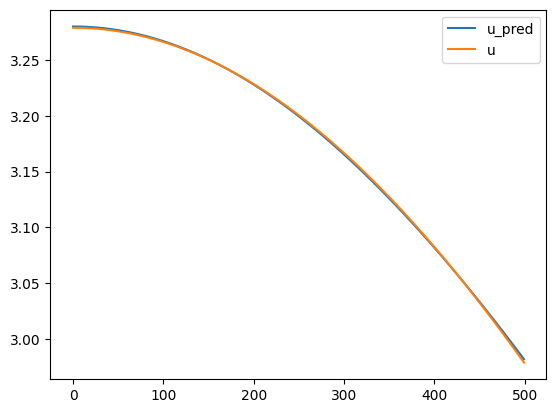

epoch 281 / 500 : loss = 0.13744418323040009
epoch 282 / 500 : loss = 0.1374000459909439
epoch 283 / 500 : loss = 0.1373562067747116
epoch 284 / 500 : loss = 0.13731175661087036


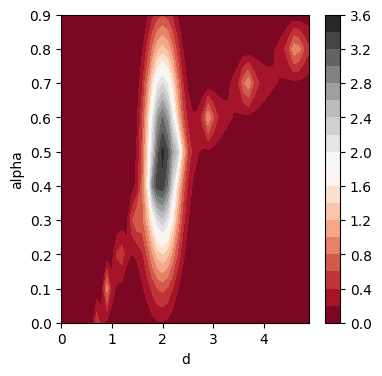

epoch 285 / 500 : loss = 0.13726821541786194


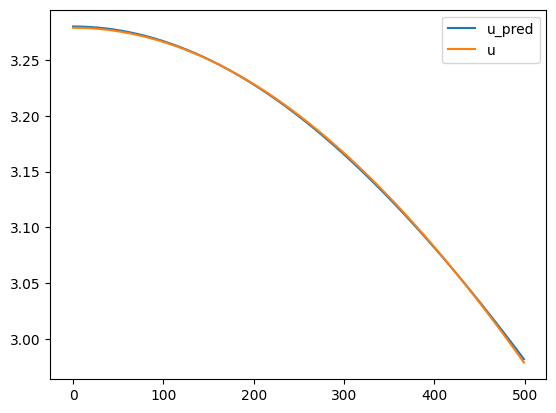

epoch 286 / 500 : loss = 0.13722410798072815
epoch 287 / 500 : loss = 0.13718029856681824
epoch 288 / 500 : loss = 0.137136310338974
epoch 289 / 500 : loss = 0.1370924562215805


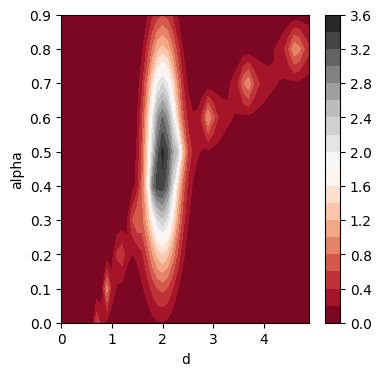

epoch 290 / 500 : loss = 0.137048602104187


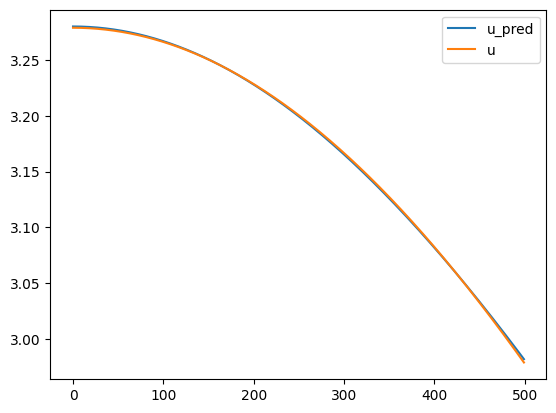

epoch 291 / 500 : loss = 0.1370050609111786
epoch 292 / 500 : loss = 0.1369614601135254
epoch 293 / 500 : loss = 0.13691745698451996
epoch 294 / 500 : loss = 0.13687463104724884


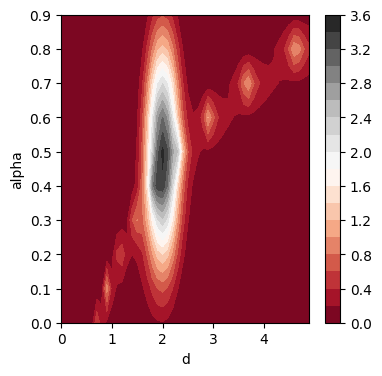

epoch 295 / 500 : loss = 0.13683180510997772


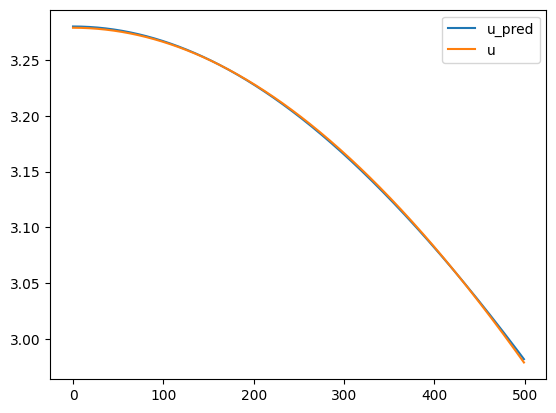

epoch 296 / 500 : loss = 0.13678902387619019
epoch 297 / 500 : loss = 0.1367456018924713
epoch 298 / 500 : loss = 0.13670259714126587
epoch 299 / 500 : loss = 0.1366596519947052


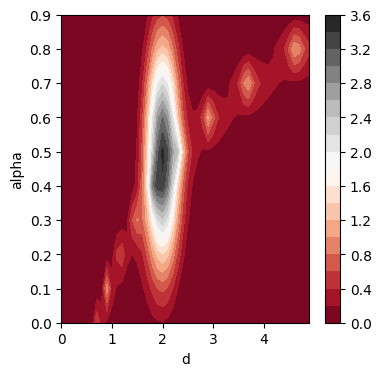

epoch 300 / 500 : loss = 0.13661669194698334


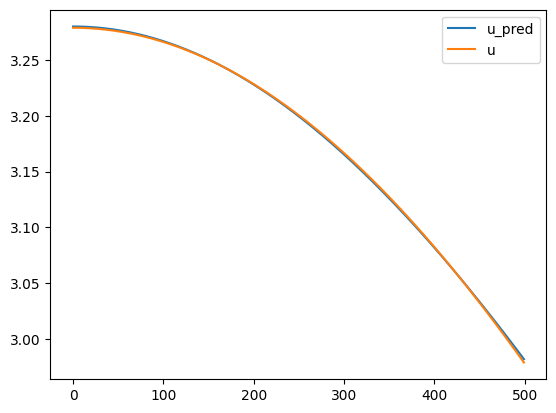

epoch 301 / 500 : loss = 0.13657429814338684
epoch 302 / 500 : loss = 0.13653133809566498
epoch 303 / 500 : loss = 0.13648861646652222
epoch 304 / 500 : loss = 0.13644550740718842


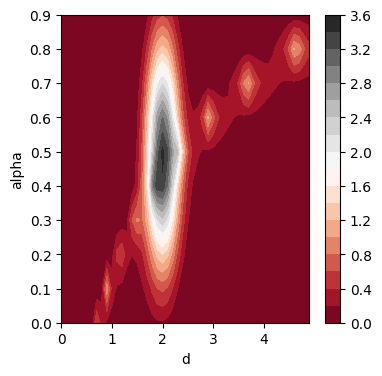

epoch 305 / 500 : loss = 0.13640272617340088


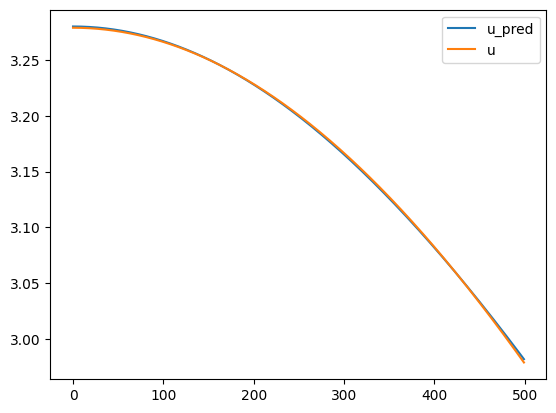

epoch 306 / 500 : loss = 0.1363602876663208
epoch 307 / 500 : loss = 0.13631759583950043
epoch 308 / 500 : loss = 0.13627518713474274
epoch 309 / 500 : loss = 0.13623254001140594


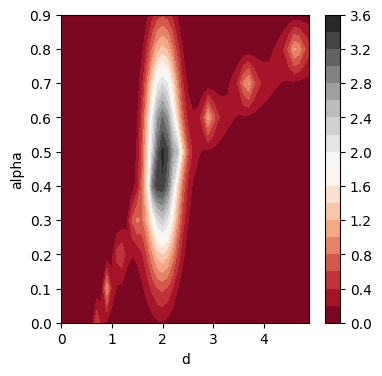

epoch 310 / 500 : loss = 0.13618990778923035


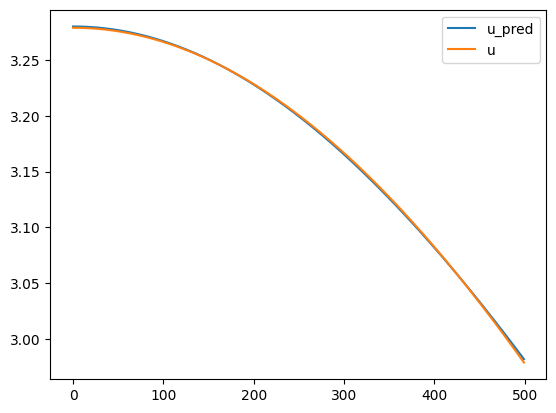

epoch 311 / 500 : loss = 0.1361476480960846
epoch 312 / 500 : loss = 0.13610495626926422
epoch 313 / 500 : loss = 0.13606242835521698
epoch 314 / 500 : loss = 0.1360200196504593


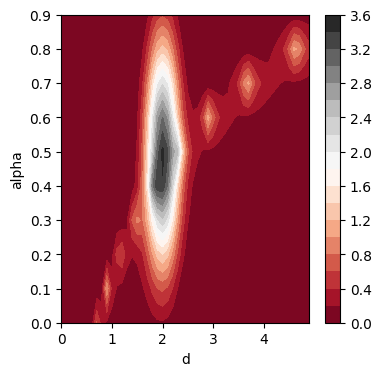

epoch 315 / 500 : loss = 0.13597755134105682


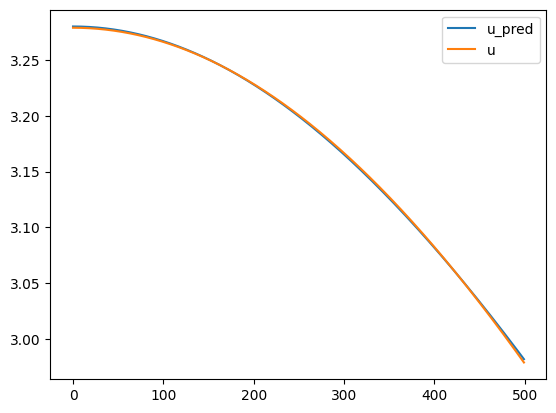

epoch 316 / 500 : loss = 0.13593487441539764
epoch 317 / 500 : loss = 0.13589243590831757
epoch 318 / 500 : loss = 0.1358499825000763
epoch 319 / 500 : loss = 0.13580793142318726


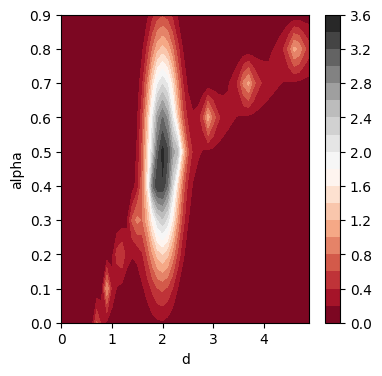

epoch 320 / 500 : loss = 0.1357654184103012


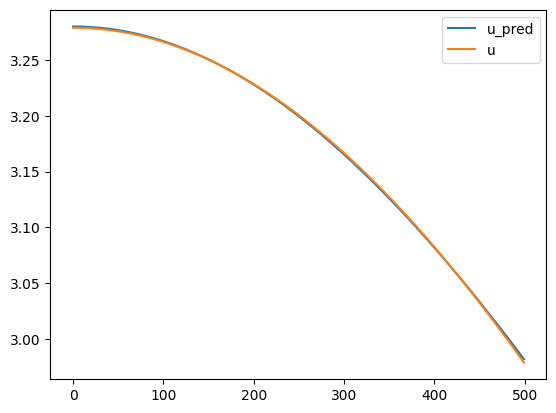

epoch 321 / 500 : loss = 0.13572335243225098
epoch 322 / 500 : loss = 0.13568098843097687
epoch 323 / 500 : loss = 0.13563871383666992
epoch 324 / 500 : loss = 0.13559651374816895


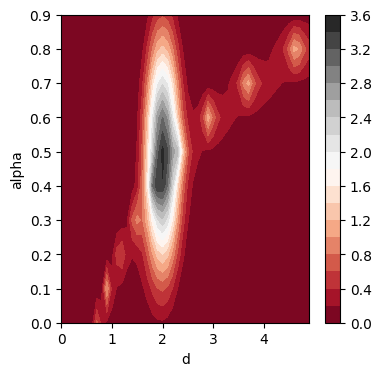

epoch 325 / 500 : loss = 0.13555482029914856


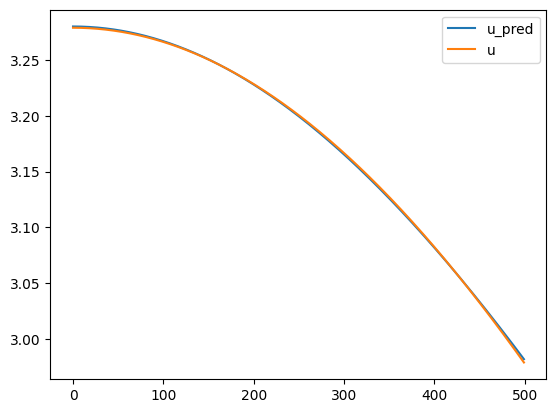

epoch 326 / 500 : loss = 0.1355127990245819
epoch 327 / 500 : loss = 0.13547101616859436
epoch 328 / 500 : loss = 0.13542920351028442
epoch 329 / 500 : loss = 0.1353876292705536


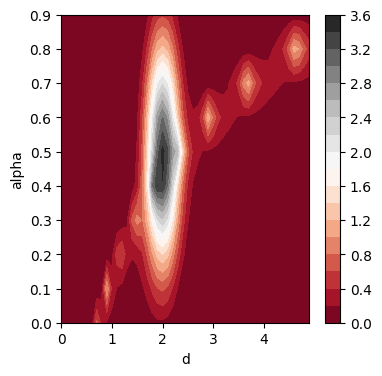

epoch 330 / 500 : loss = 0.13534587621688843


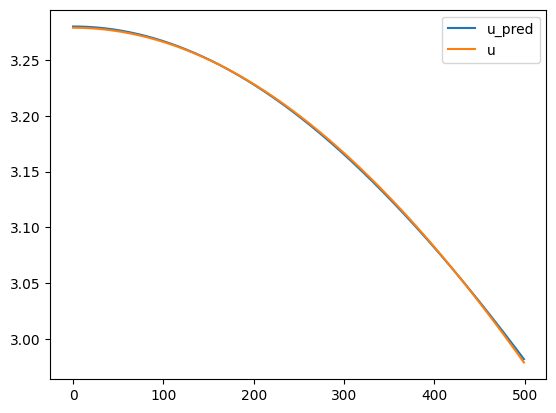

epoch 331 / 500 : loss = 0.13530412316322327
epoch 332 / 500 : loss = 0.1352628469467163
epoch 333 / 500 : loss = 0.13522101938724518
epoch 334 / 500 : loss = 0.13517984747886658


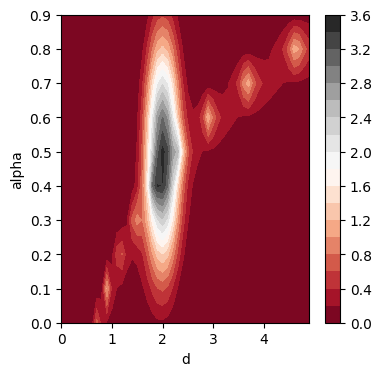

epoch 335 / 500 : loss = 0.13513848185539246


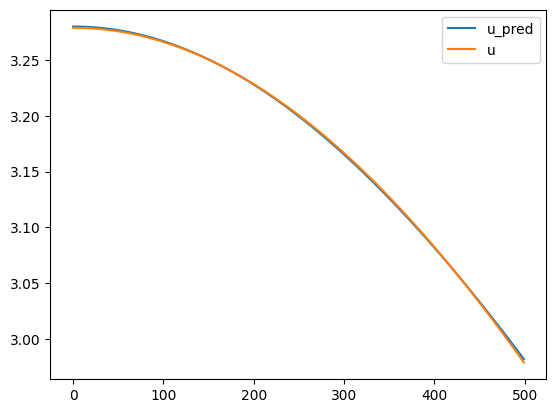

epoch 336 / 500 : loss = 0.13509687781333923
epoch 337 / 500 : loss = 0.13505567610263824
epoch 338 / 500 : loss = 0.1350143998861313
epoch 339 / 500 : loss = 0.13497307896614075


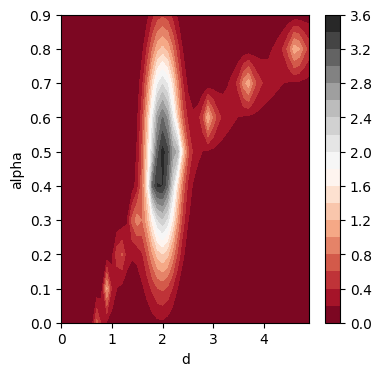

epoch 340 / 500 : loss = 0.134932279586792


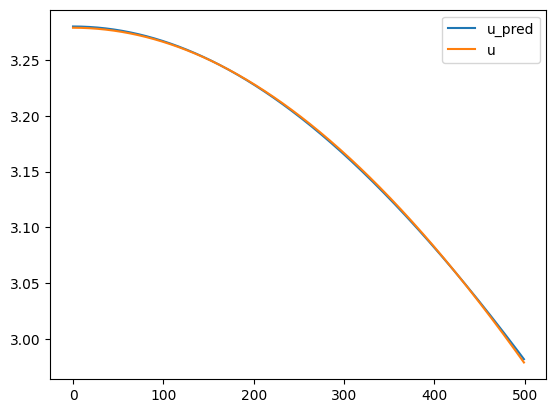

epoch 341 / 500 : loss = 0.13489116728305817
epoch 342 / 500 : loss = 0.13484975695610046
epoch 343 / 500 : loss = 0.13480879366397858
epoch 344 / 500 : loss = 0.13476750254631042


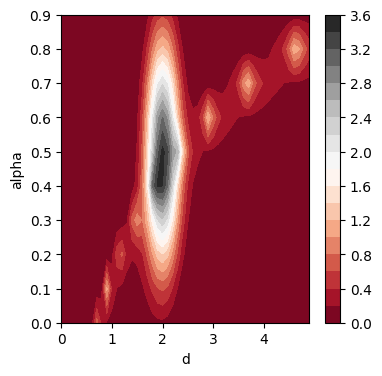

epoch 345 / 500 : loss = 0.13472644984722137


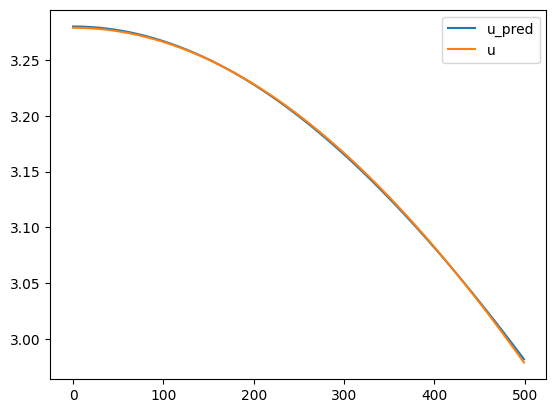

epoch 346 / 500 : loss = 0.13468554615974426
epoch 347 / 500 : loss = 0.13464514911174774
epoch 348 / 500 : loss = 0.13460509479045868
epoch 349 / 500 : loss = 0.13456536829471588


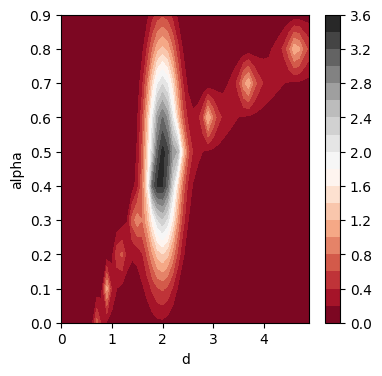

epoch 350 / 500 : loss = 0.13452552258968353


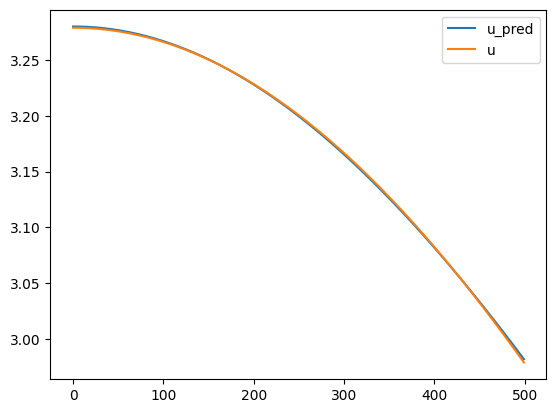

epoch 351 / 500 : loss = 0.13448573648929596
epoch 352 / 500 : loss = 0.13444571197032928
epoch 353 / 500 : loss = 0.13440562784671783
epoch 354 / 500 : loss = 0.1343657523393631


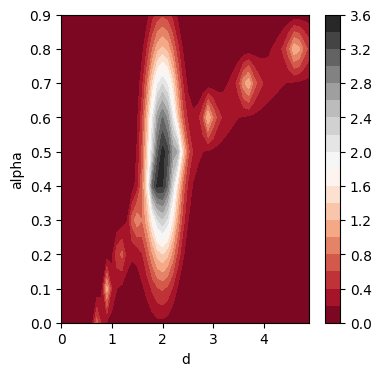

epoch 355 / 500 : loss = 0.13432613015174866


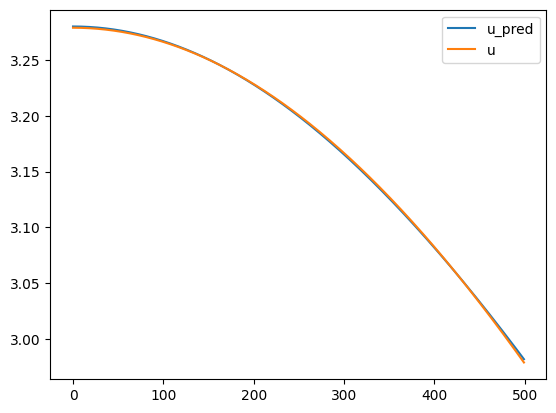

epoch 356 / 500 : loss = 0.13428626954555511
epoch 357 / 500 : loss = 0.13424646854400635
epoch 358 / 500 : loss = 0.13420672714710236
epoch 359 / 500 : loss = 0.13416710495948792


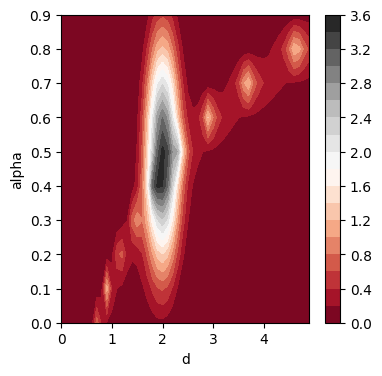

epoch 360 / 500 : loss = 0.13412725925445557


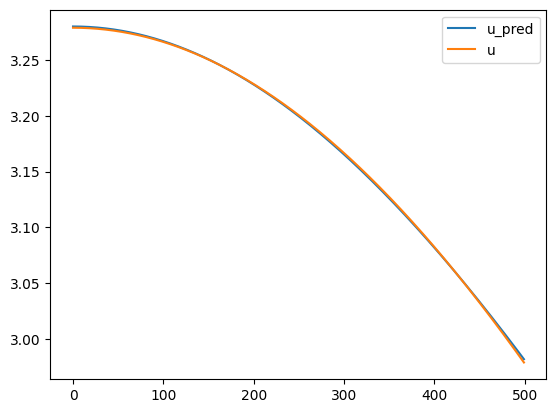

epoch 361 / 500 : loss = 0.13408778607845306
epoch 362 / 500 : loss = 0.13404810428619385
epoch 363 / 500 : loss = 0.1340084671974182
epoch 364 / 500 : loss = 0.13396918773651123


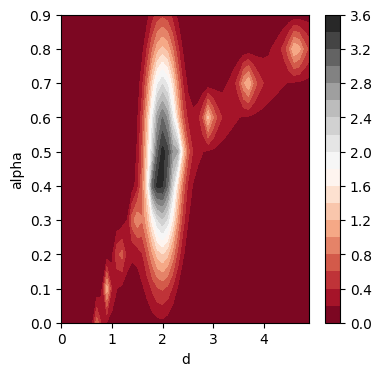

epoch 365 / 500 : loss = 0.13392968475818634


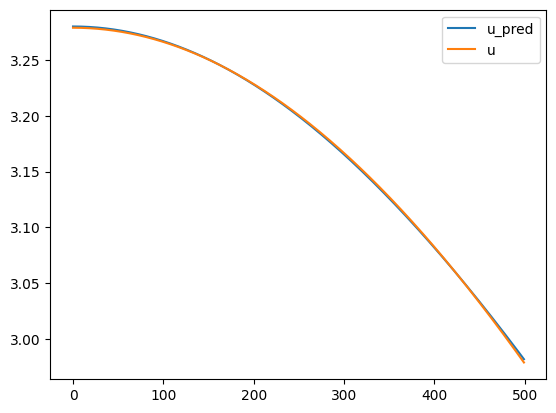

epoch 366 / 500 : loss = 0.13389036059379578
epoch 367 / 500 : loss = 0.13385096192359924
epoch 368 / 500 : loss = 0.13381175696849823
epoch 369 / 500 : loss = 0.13377276062965393


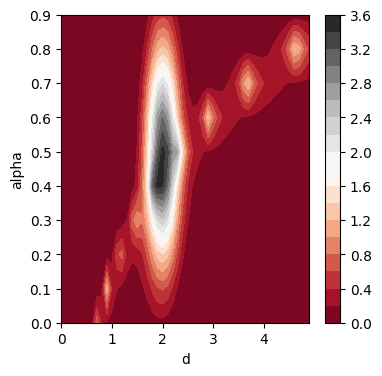

epoch 370 / 500 : loss = 0.13373352587223053


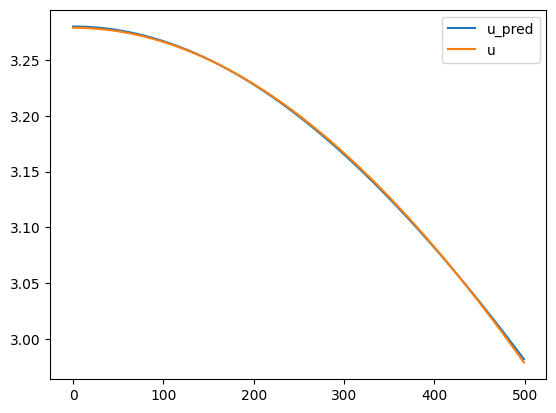

epoch 371 / 500 : loss = 0.13369420170783997
epoch 372 / 500 : loss = 0.13365493714809418
epoch 373 / 500 : loss = 0.13361583650112152
epoch 374 / 500 : loss = 0.13357651233673096


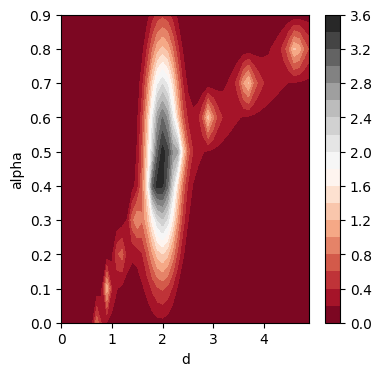

epoch 375 / 500 : loss = 0.1335376352071762


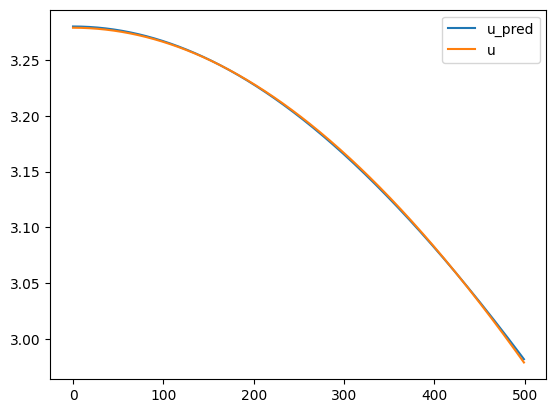

epoch 376 / 500 : loss = 0.13349832594394684
epoch 377 / 500 : loss = 0.13345929980278015
epoch 378 / 500 : loss = 0.13342036306858063
epoch 379 / 500 : loss = 0.13338132202625275


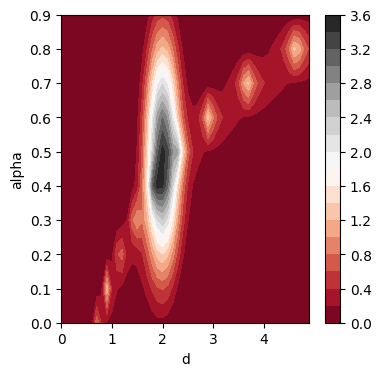

epoch 380 / 500 : loss = 0.13334213197231293


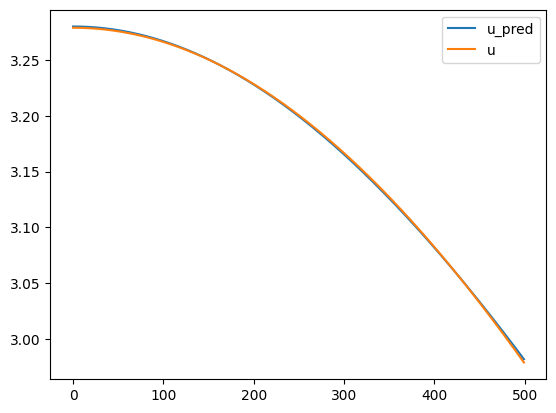

epoch 381 / 500 : loss = 0.13330326974391937
epoch 382 / 500 : loss = 0.13326434791088104
epoch 383 / 500 : loss = 0.1332252472639084
epoch 384 / 500 : loss = 0.13318660855293274


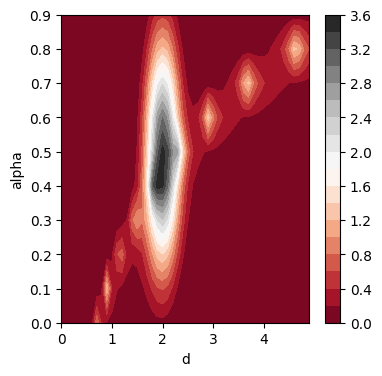

epoch 385 / 500 : loss = 0.1331479400396347


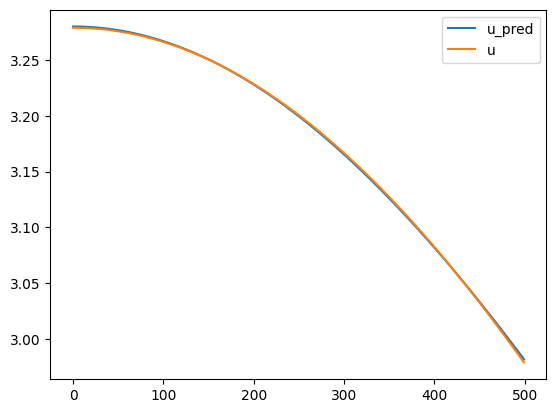

epoch 386 / 500 : loss = 0.13310889899730682
epoch 387 / 500 : loss = 0.13306991755962372
epoch 388 / 500 : loss = 0.13303135335445404
epoch 389 / 500 : loss = 0.13299281895160675


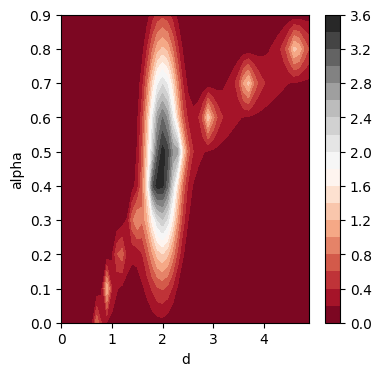

epoch 390 / 500 : loss = 0.13295383751392365


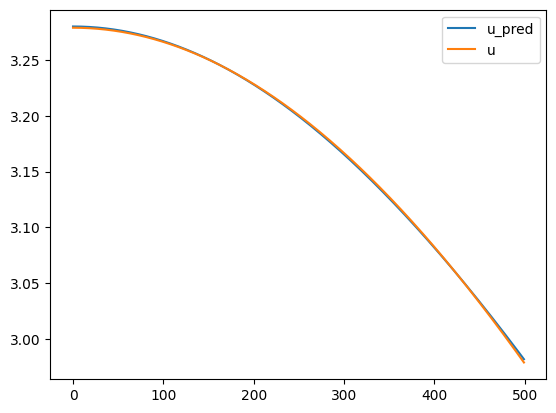

epoch 391 / 500 : loss = 0.1329151690006256
epoch 392 / 500 : loss = 0.13287648558616638
epoch 393 / 500 : loss = 0.13283774256706238
epoch 394 / 500 : loss = 0.1327989399433136


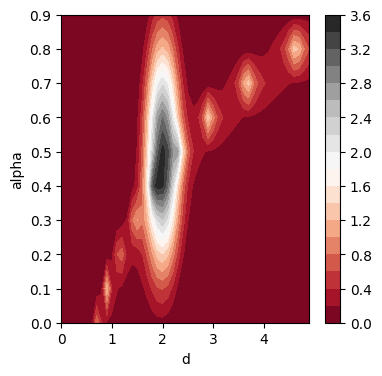

epoch 395 / 500 : loss = 0.1327601671218872


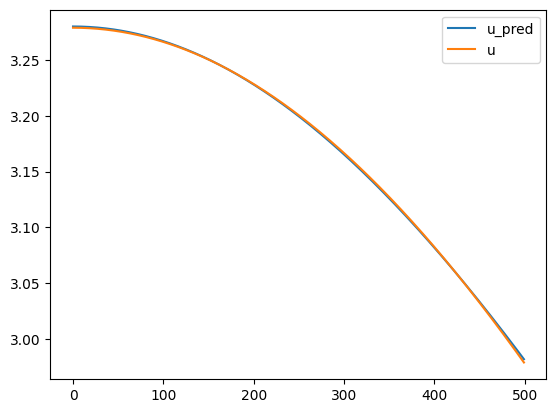

epoch 396 / 500 : loss = 0.1327216625213623
epoch 397 / 500 : loss = 0.13268305361270905
epoch 398 / 500 : loss = 0.1326441913843155
epoch 399 / 500 : loss = 0.13260559737682343


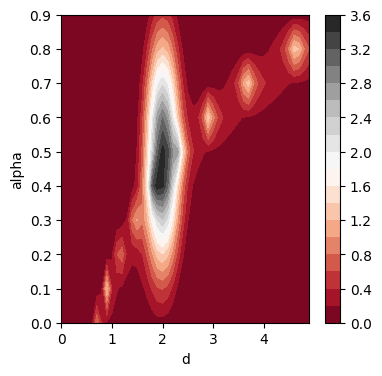

epoch 400 / 500 : loss = 0.1325671225786209


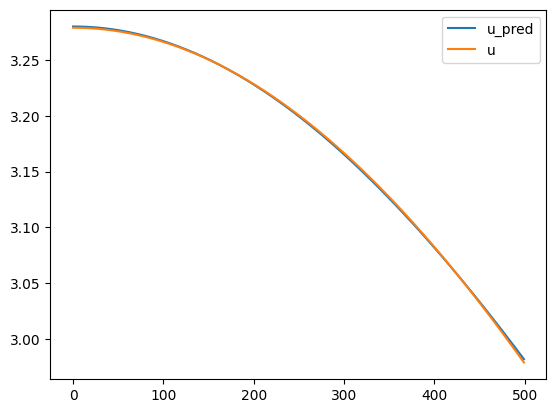

epoch 401 / 500 : loss = 0.1325283795595169
epoch 402 / 500 : loss = 0.1324896365404129
epoch 403 / 500 : loss = 0.132451131939888
epoch 404 / 500 : loss = 0.13241274654865265


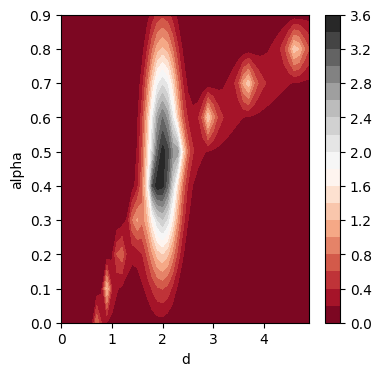

epoch 405 / 500 : loss = 0.13237416744232178


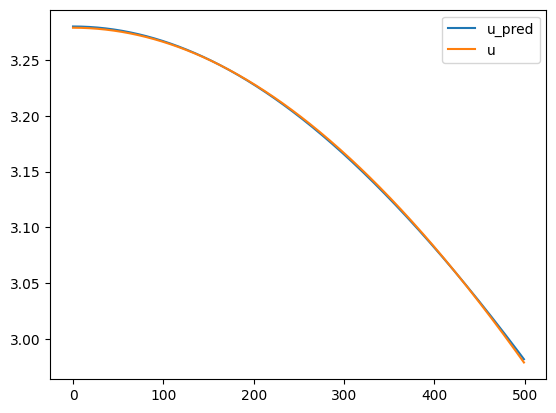

epoch 406 / 500 : loss = 0.13233602046966553
epoch 407 / 500 : loss = 0.13229748606681824
epoch 408 / 500 : loss = 0.1322593092918396
epoch 409 / 500 : loss = 0.13222075998783112


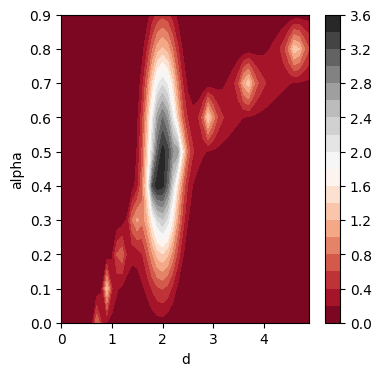

epoch 410 / 500 : loss = 0.1321822702884674


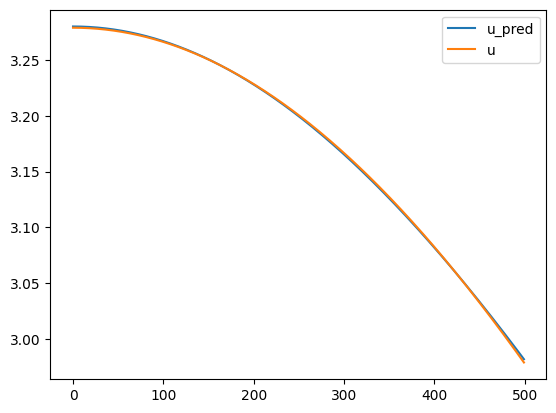

epoch 411 / 500 : loss = 0.13214415311813354
epoch 412 / 500 : loss = 0.13210564851760864
epoch 413 / 500 : loss = 0.13206756114959717
epoch 414 / 500 : loss = 0.1320292055606842


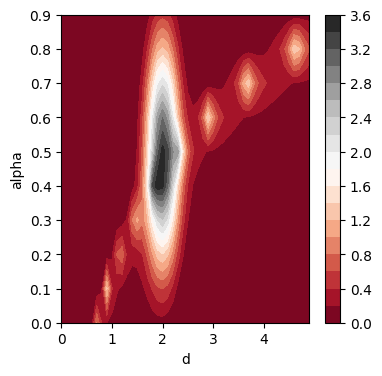

epoch 415 / 500 : loss = 0.13199087977409363


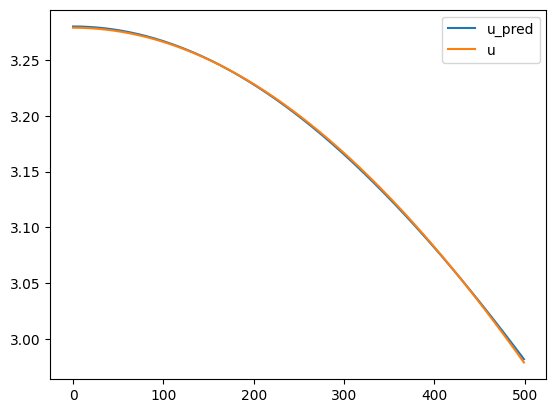

epoch 416 / 500 : loss = 0.13195253908634186
epoch 417 / 500 : loss = 0.13191424310207367
epoch 418 / 500 : loss = 0.13187623023986816
epoch 419 / 500 : loss = 0.13183775544166565


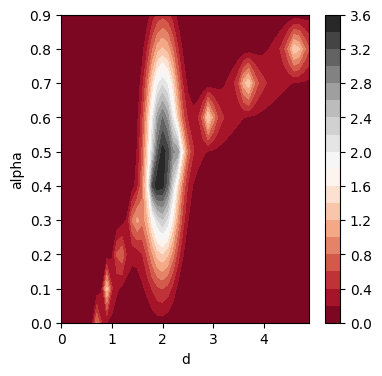

epoch 420 / 500 : loss = 0.13179975748062134


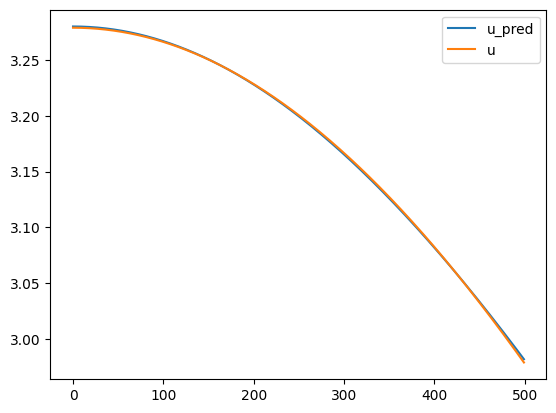

epoch 421 / 500 : loss = 0.13176146149635315
epoch 422 / 500 : loss = 0.13172321021556854
epoch 423 / 500 : loss = 0.1316850632429123
epoch 424 / 500 : loss = 0.1316472887992859


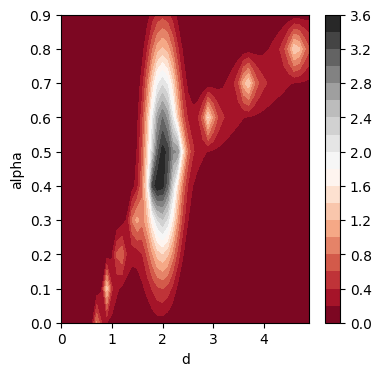

epoch 425 / 500 : loss = 0.1316087692975998


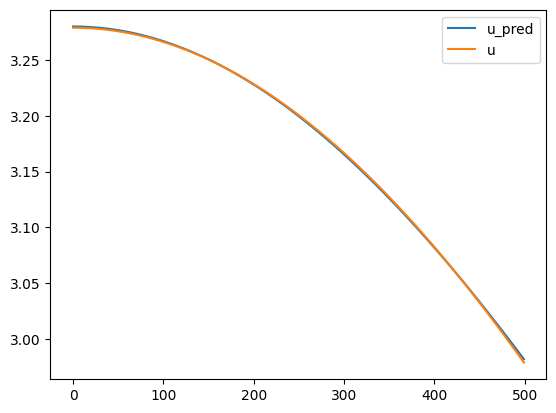

epoch 426 / 500 : loss = 0.131570965051651
epoch 427 / 500 : loss = 0.1315329223871231
epoch 428 / 500 : loss = 0.1314947009086609
epoch 429 / 500 : loss = 0.13145668804645538


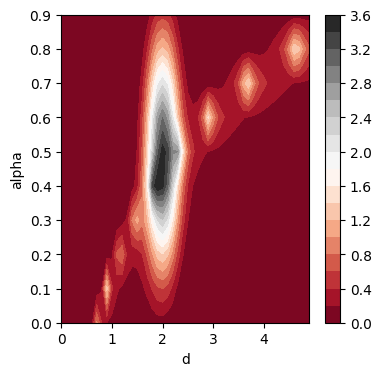

epoch 430 / 500 : loss = 0.13141845166683197


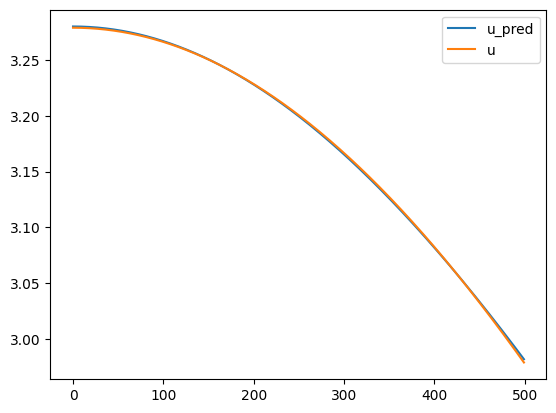

epoch 431 / 500 : loss = 0.13138078153133392
epoch 432 / 500 : loss = 0.13134276866912842
epoch 433 / 500 : loss = 0.13130474090576172
epoch 434 / 500 : loss = 0.13126656413078308


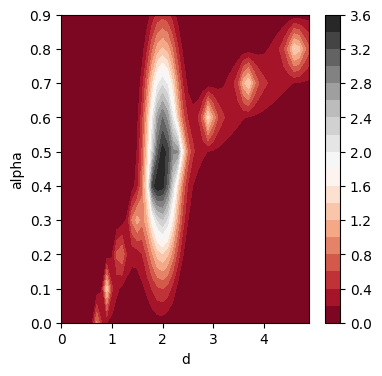

epoch 435 / 500 : loss = 0.1312287300825119


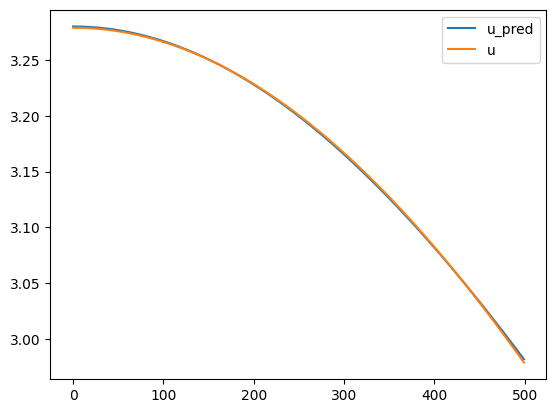

epoch 436 / 500 : loss = 0.13119083642959595
epoch 437 / 500 : loss = 0.13115288317203522
epoch 438 / 500 : loss = 0.13111524283885956
epoch 439 / 500 : loss = 0.1310771107673645


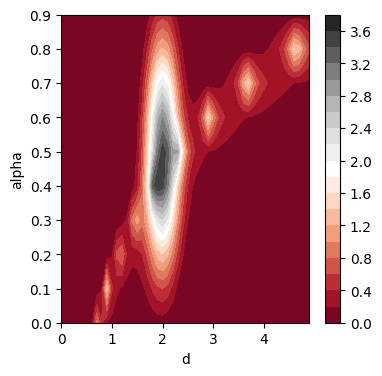

epoch 440 / 500 : loss = 0.13103915750980377


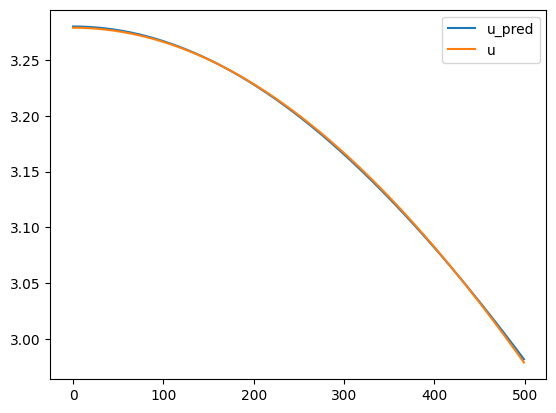

epoch 441 / 500 : loss = 0.13100124895572662
epoch 442 / 500 : loss = 0.13096365332603455
epoch 443 / 500 : loss = 0.13092580437660217
epoch 444 / 500 : loss = 0.1308884471654892


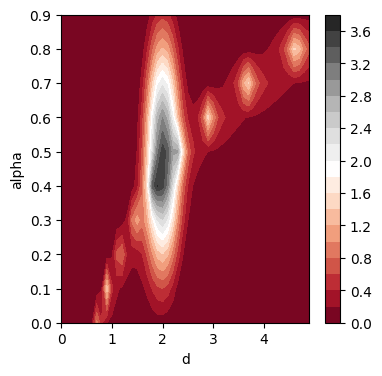

epoch 445 / 500 : loss = 0.1308513730764389


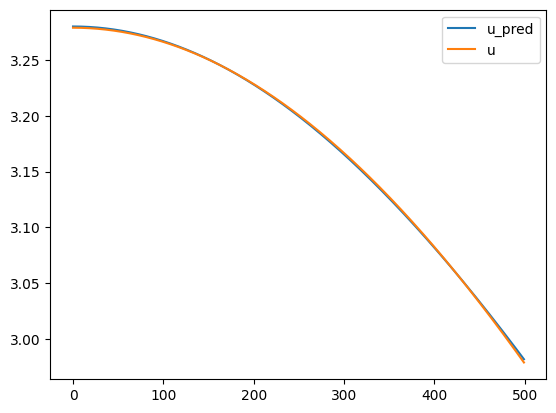

epoch 446 / 500 : loss = 0.130814328789711
epoch 447 / 500 : loss = 0.1307770013809204
epoch 448 / 500 : loss = 0.1307399570941925
epoch 449 / 500 : loss = 0.13070271909236908


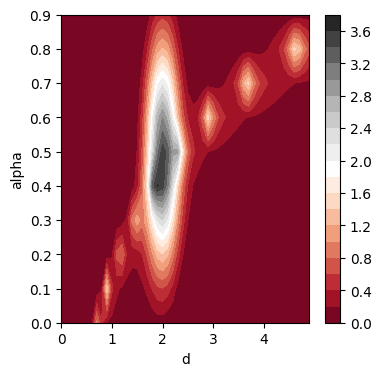

epoch 450 / 500 : loss = 0.13066555559635162


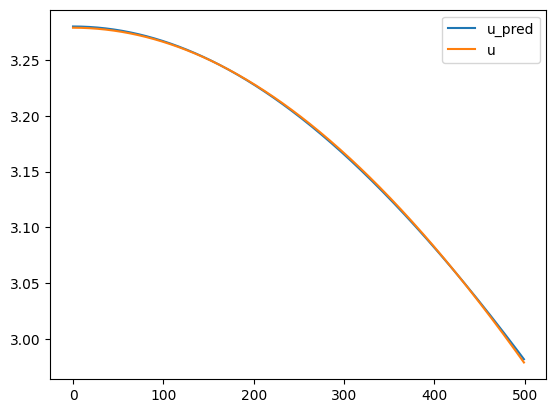

epoch 451 / 500 : loss = 0.13062870502471924
epoch 452 / 500 : loss = 0.13059154152870178
epoch 453 / 500 : loss = 0.1305544376373291
epoch 454 / 500 : loss = 0.1305173933506012


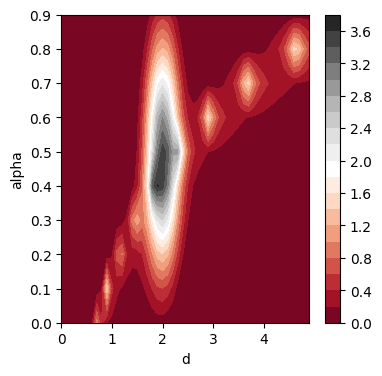

epoch 455 / 500 : loss = 0.13048002123832703


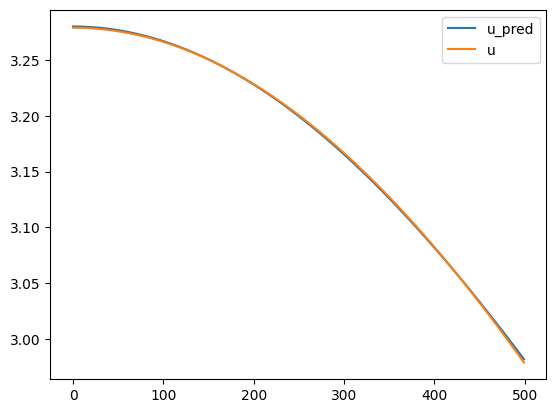

epoch 456 / 500 : loss = 0.13044311106204987
epoch 457 / 500 : loss = 0.13040609657764435
epoch 458 / 500 : loss = 0.13036875426769257
epoch 459 / 500 : loss = 0.130331888794899


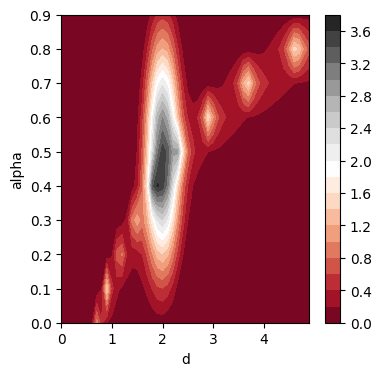

epoch 460 / 500 : loss = 0.1302947998046875


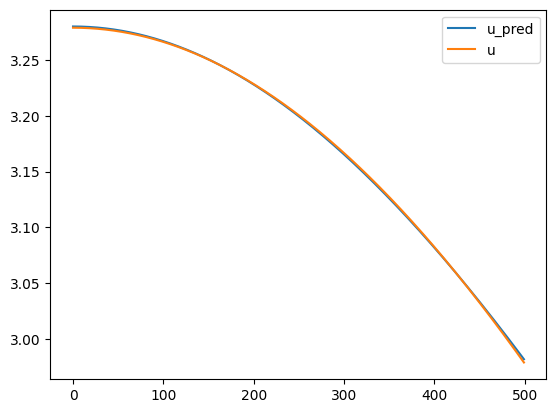

epoch 461 / 500 : loss = 0.13025766611099243
epoch 462 / 500 : loss = 0.13022059202194214
epoch 463 / 500 : loss = 0.13018371164798737
epoch 464 / 500 : loss = 0.130146786570549


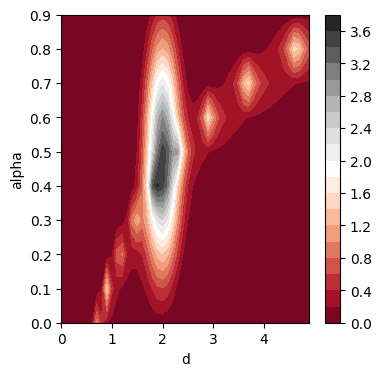

epoch 465 / 500 : loss = 0.1301097571849823


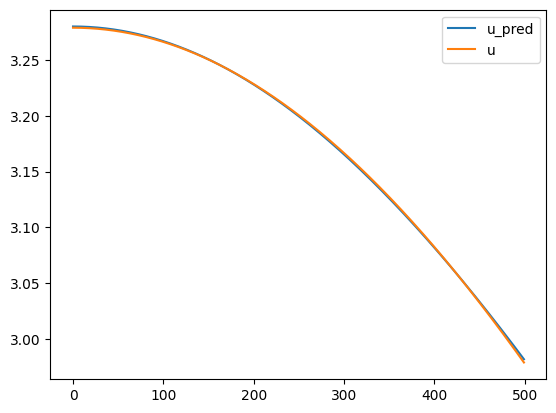

epoch 466 / 500 : loss = 0.1300733983516693
epoch 467 / 500 : loss = 0.13003689050674438
epoch 468 / 500 : loss = 0.13000039756298065
epoch 469 / 500 : loss = 0.1299639195203781


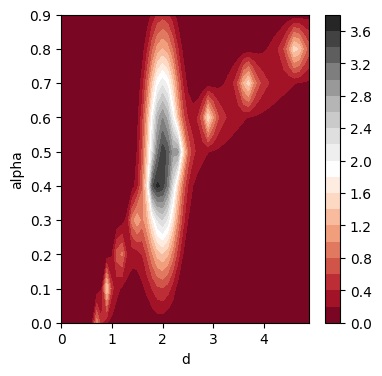

epoch 470 / 500 : loss = 0.1299273520708084


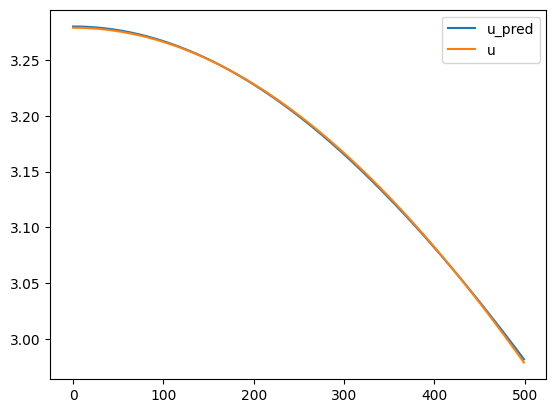

epoch 471 / 500 : loss = 0.12989115715026855
epoch 472 / 500 : loss = 0.12985438108444214
epoch 473 / 500 : loss = 0.12981823086738586
epoch 474 / 500 : loss = 0.1297817826271057


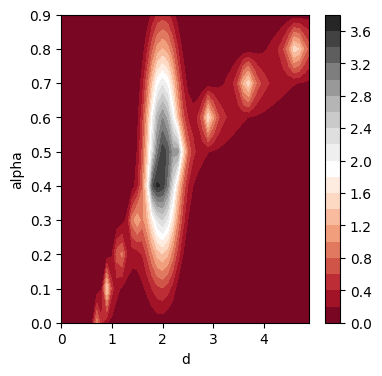

epoch 475 / 500 : loss = 0.12974593043327332


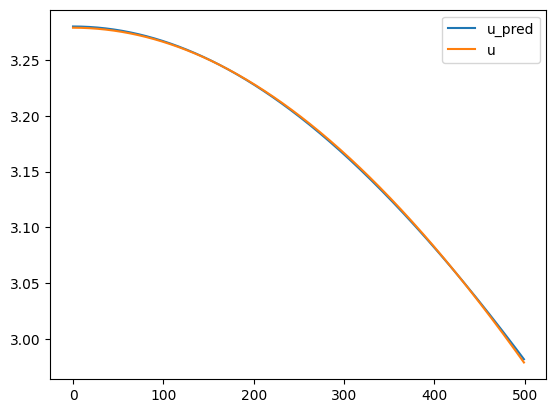

epoch 476 / 500 : loss = 0.12970982491970062
epoch 477 / 500 : loss = 0.1296740621328354
epoch 478 / 500 : loss = 0.1296376883983612
epoch 479 / 500 : loss = 0.1296016126871109


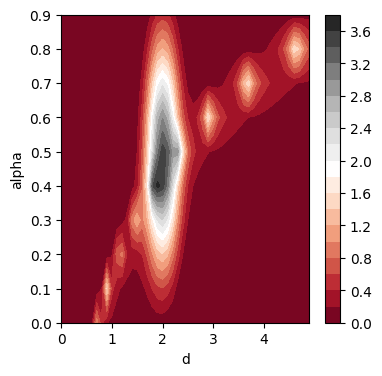

epoch 480 / 500 : loss = 0.1295655518770218


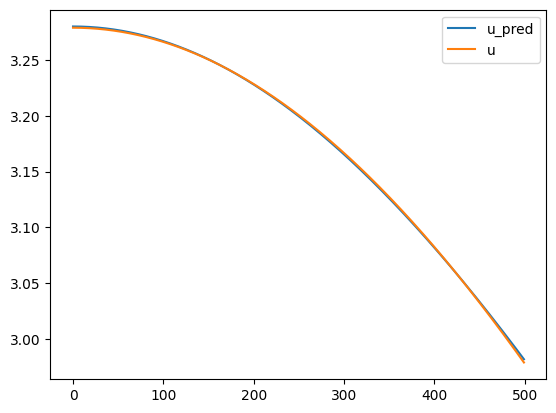

epoch 481 / 500 : loss = 0.1295294463634491
epoch 482 / 500 : loss = 0.12949389219284058
epoch 483 / 500 : loss = 0.12945806980133057
epoch 484 / 500 : loss = 0.12942218780517578


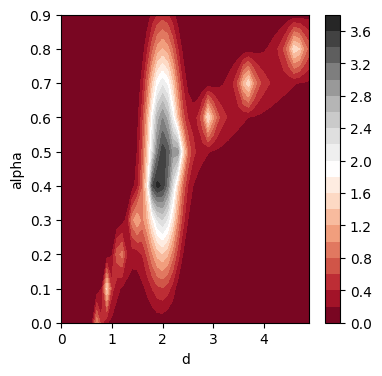

epoch 485 / 500 : loss = 0.12938636541366577


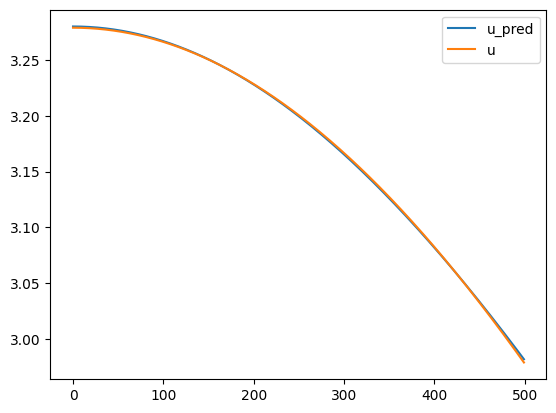

epoch 486 / 500 : loss = 0.1293502151966095
epoch 487 / 500 : loss = 0.12931473553180695
epoch 488 / 500 : loss = 0.12927889823913574
epoch 489 / 500 : loss = 0.1292429268360138


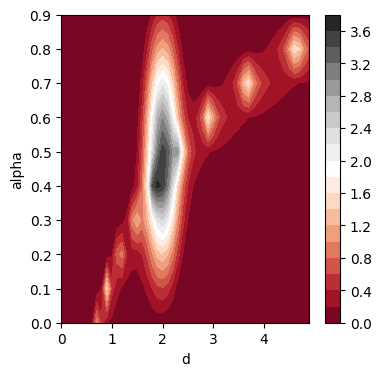

epoch 490 / 500 : loss = 0.12920719385147095


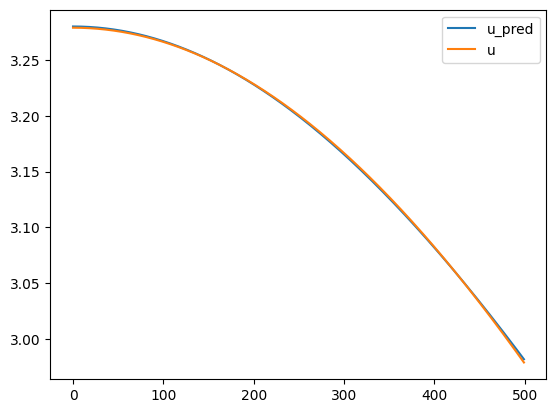

epoch 491 / 500 : loss = 0.1291711926460266
epoch 492 / 500 : loss = 0.12913548946380615
epoch 493 / 500 : loss = 0.1291000097990036
epoch 494 / 500 : loss = 0.1290643960237503


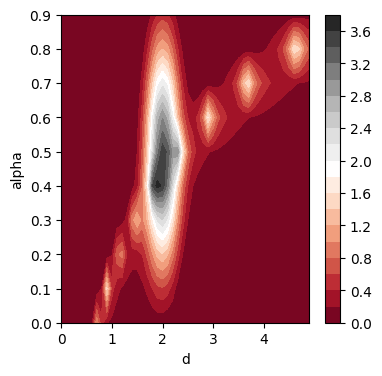

epoch 495 / 500 : loss = 0.1290283054113388


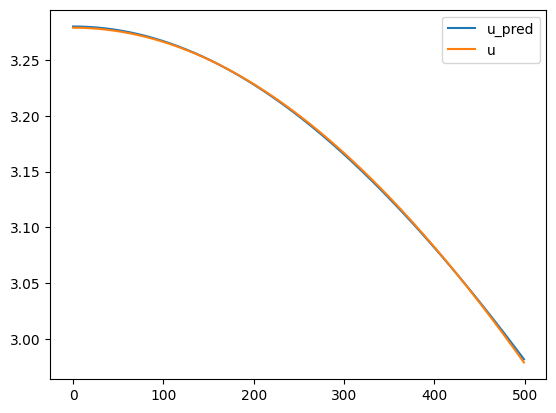

epoch 496 / 500 : loss = 0.12899281084537506
epoch 497 / 500 : loss = 0.12895680963993073
epoch 498 / 500 : loss = 0.1289213001728058
epoch 499 / 500 : loss = 0.12888561189174652


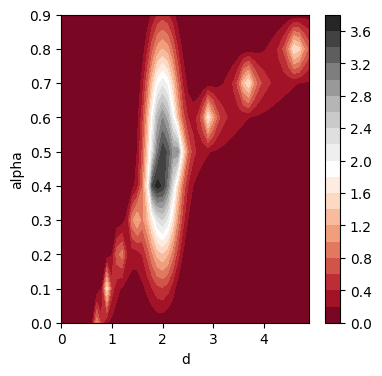

epoch 500 / 500 : loss = 0.12885001301765442


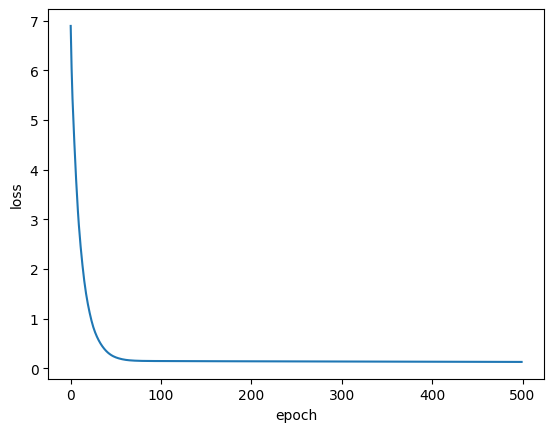

In [138]:
# train the model
P_alpha_d = train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=500, lr=1e-2)

In [139]:
P_alpha_d_cpu = P_alpha_d.cpu().detach().numpy()
# normalize P_alpha_d_cpu
# P_alpha_d_cpu = P_alpha_d_cpu / (P_alpha_d_cpu.sum(axis=(1,2), keepdims=True))
print(f"shape of P_alpha_d_cpu : {P_alpha_d_cpu.shape}")
# save P_alpha_d_cpu
np.save("P_alpha_d_cpu.npy", P_alpha_d_cpu)

shape of P_alpha_d_cpu : (100, 10, 50)


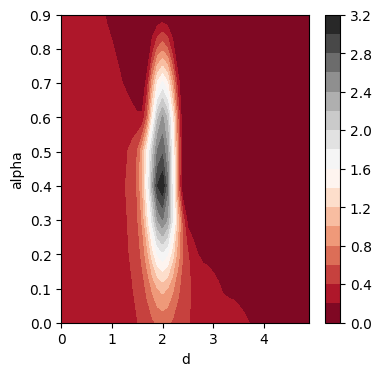

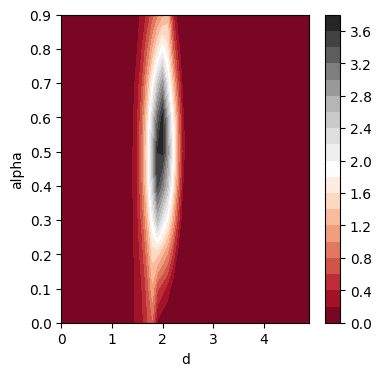

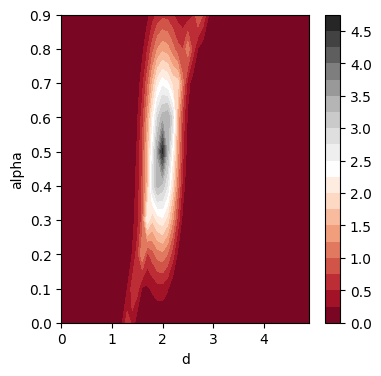

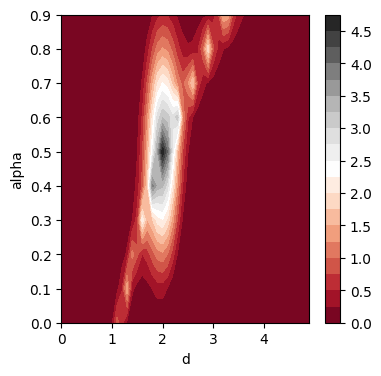

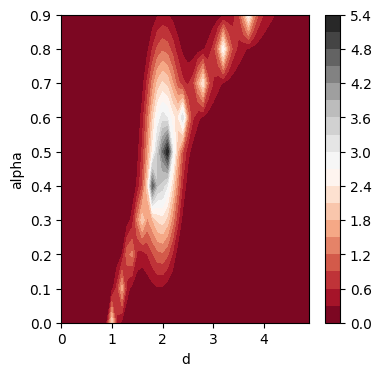

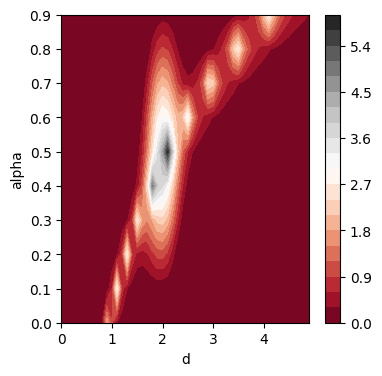

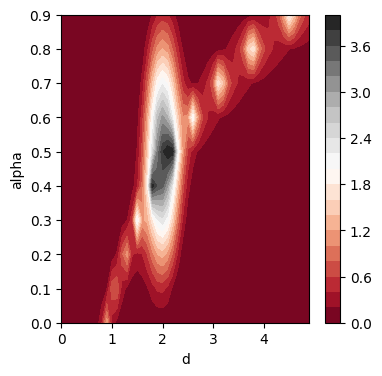

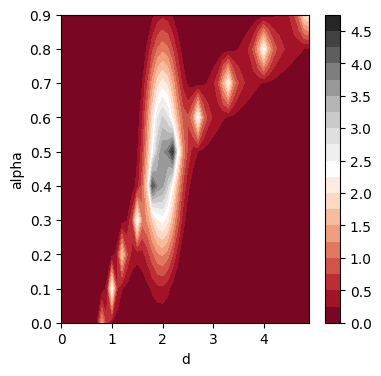

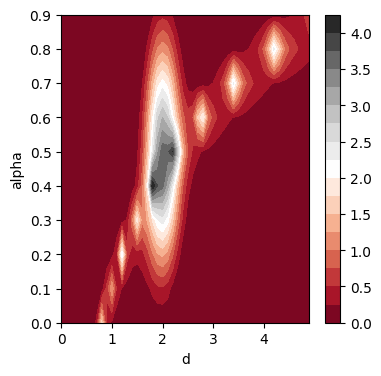

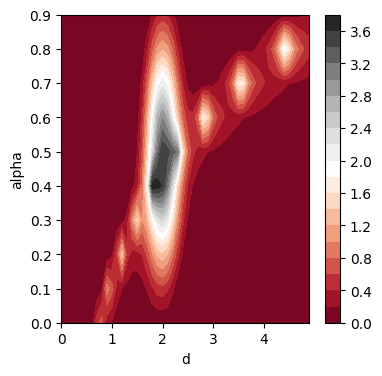

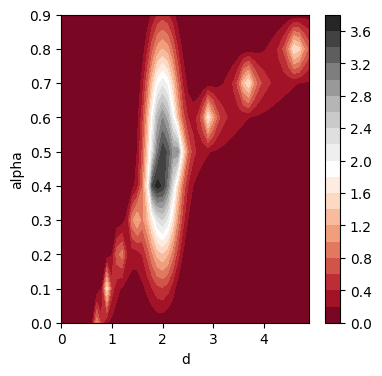

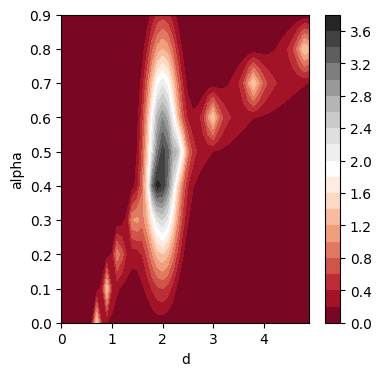

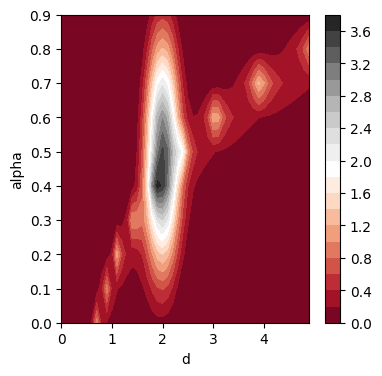

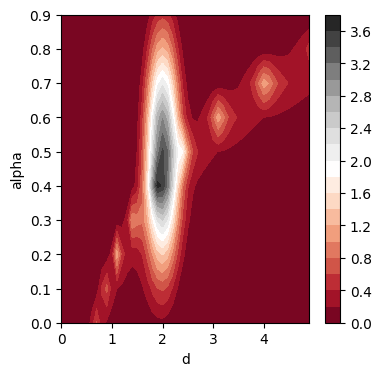

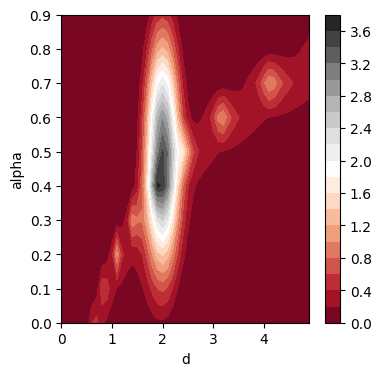

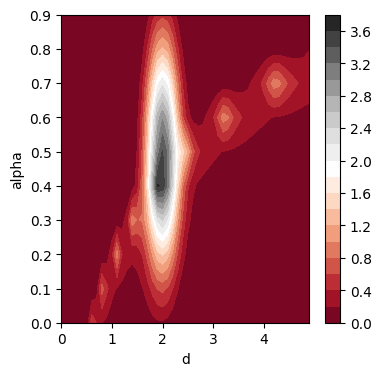

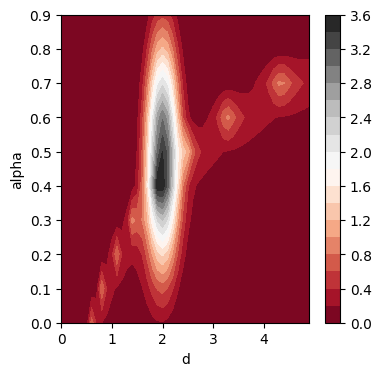

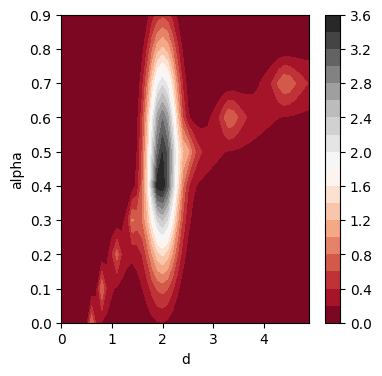

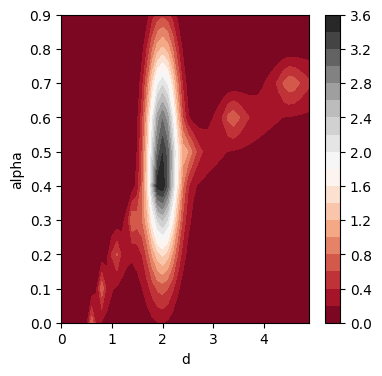

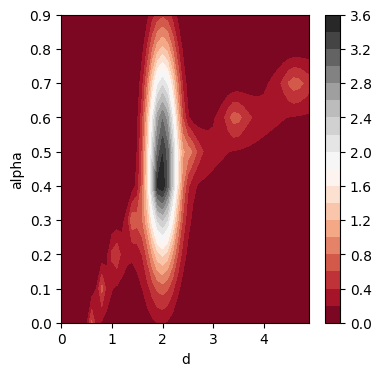

In [140]:
for i in range(0, num_frames, 5):
    # copy P_alpha_d to cpu
    contour_plt(P_alpha_d_cpu, i)

In [141]:
def give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = np.zeros((num_frames, len(r_vals)))

    # convert P_alpha_d to numpy array
    P_alpha_d = P_alpha_d.cpu().detach().numpy()
    Z = Z.cpu().detach().numpy()
    alpha_vals = alpha_vals.cpu().detach().numpy()
    d_vals = d_vals.cpu().detach().numpy()

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = np.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals, axis=1)
            u_pred[i, j] = np.trapz(integrand, alpha_vals)

    # normalize u_pred
    u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True) + 1e-6)
    # u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True))

    # s_vals = np.linspace(0.0, 2*np.pi, 101)
    s_vals = np.linspace(0.1, 20.1, 101)
    # s_vals[0] = 1e-10
    s_vals = s_vals[:-1]

    # get the range of k values
    # convert r_vals to numpy array
    r_vals = r_vals.cpu().detach().numpy()
    k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
    k_vals = fft.fftshift(k_vals)
    # k_vals = 2 * np.pi * k_vals
    # print(k_vals)
    print(f"shape of k_vals : {k_vals.shape}")

    # visualize u_pred
    plt.figure(figsize=(10, 8))
    plt.title("u_pred(s, k) for some s values")
    plt.xlabel("k")
    plt.ylabel("u_pred(s, k)")
    plt.grid()
    for i in range(0, s_vals.shape[0], 10):
        if i == 0:
            continue
        plt.plot(k_vals, u_pred[i, :], label=f"s = {s_vals[i]:.2f}")

    plt.legend()
    plt.show()

shape of k_vals : (500,)


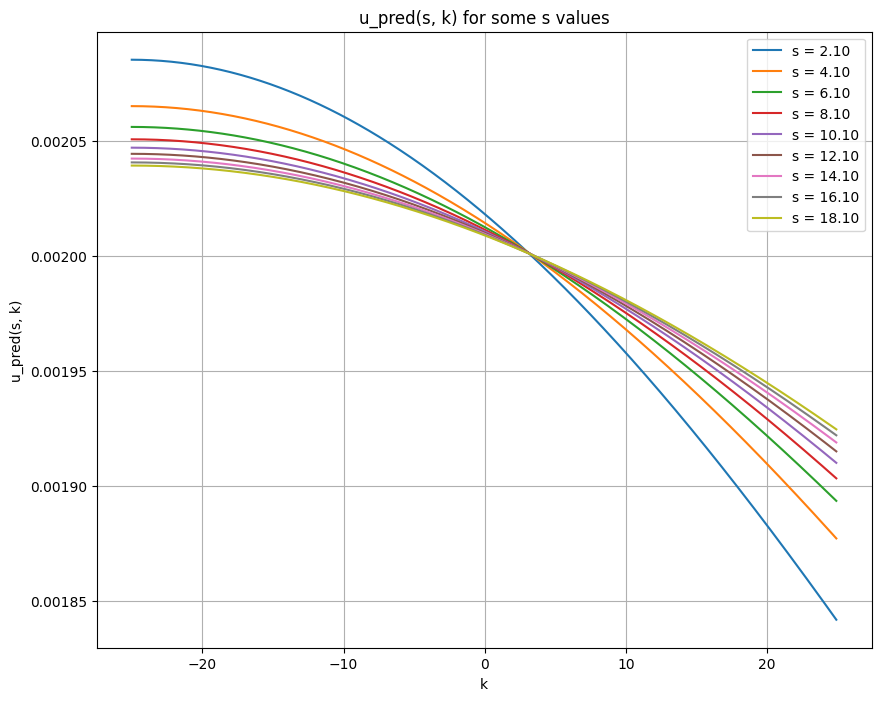

In [142]:
# reproduce u_pred
give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals)
